In [1]:
# -*- coding: utf-8 -*-
"""
# Análisis del Impacto Afectivo de Herramientas Digitales Interactivas
## Objetivo Específico 2: Identificar los efectos en resultados afectivos (motivación, compromiso, ansiedad y respuestas emocionales)

Este notebook implementa análisis estadísticos apropiados para muestras pequeñas (29 registros)
y genera visualizaciones de alto impacto para responder al objetivo específico 2.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import bigrams, trigrams
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
import textwrap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter
# Asegúrate de tener estas importaciones, usualmente al inicio del script
try:
    from nltk.util import bigrams, trigrams
    from sklearn.feature_extraction.text import TfidfVectorizer
    NLTK_AVAILABLE = True
except ImportError:
    print("Advertencia: NLTK o Scikit-learn no encontrados. Análisis de N-gramas y TF-IDF no se realizarán.")
    NLTK_AVAILABLE = False
    # Crear funciones dummy si no están disponibles para evitar NameErrors más adelante
    def bigrams(x): return []
    def trigrams(x): return []
    class TfidfVectorizer:
        def __init__(self, *args, **kwargs): pass
        def fit_transform(self, x): raise NotImplementedError("TF-IDF no disponible")
        def get_feature_names_out(self): raise NotImplementedError("TF-IDF no disponible")

In [42]:


# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'

# Crear directorio para guardar resultados
RESULTS_DIR = "ResObj02b"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Directorio para resultados creado: {RESULTS_DIR}")

# Constantes para el análisis
COL_MOTIVATION = "Impacto Afectivo: Motivación y Compromiso"
COL_ANXIETY = "Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales"
COL_EFFECT_SIZES = "Effect Sizes"
COL_TOOLS = "Herramientas Digitales: Tipos de Herramientas Interactivas"
COL_AUTHORS = "Authors"
COL_YEAR = "Year"
COL_COUNTRY = "Country"
COL_SAMPLE_SIZE = "Sample Size"
COL_TOOLS_EFFICACY = "Herramientas Digitales: Eficacia de Herramientas"

# Paletas de colores personalizadas
MOTIVATION_PALETTE = sns.color_palette("viridis", 7)
ANXIETY_PALETTE = sns.color_palette("rocket", 7)
YEAR_PALETTE = sns.color_palette("YlOrRd", 8)
RELATION_COLORS = {'positivo': '#1b9e77', 'neutro': '#d95f02', 'negativo': '#7570b3'}

print("Cargando y configurando bibliotecas NLP...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    spanish_stopwords = set(stopwords.words('spanish'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = spanish_stopwords.union(english_stopwords)
    print("Bibliotecas NLP cargadas correctamente")
except Exception as e:
    print(f"Error al cargar bibliotecas NLP: {e}")
    all_stopwords = set()  # Set vacío como fallback

# Función para preprocesar texto
def preprocess_text(text, remove_stopwords=True):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Tokenizar
    tokens = word_tokenize(text)
    
    # Remover stopwords si se solicita
    if remove_stopwords:
        tokens = [token for token in tokens if token not in all_stopwords]
    
    # Remover tokens de un solo caracter y números
    tokens = [token for token in tokens if len(token) > 1 and not token.isdigit()]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return " ".join(tokens)

# Cargar datos
def load_data(file_path='analisisTodos.csv'):
    print(f"Cargando datos desde {file_path}...")
    try:
        df = pd.read_csv(file_path, sep=';', encoding='utf-8')
        print(f"Datos cargados correctamente. {len(df)} registros encontrados.")
        
        # Verificar columnas necesarias
        required_cols = [COL_MOTIVATION, COL_ANXIETY, COL_EFFECT_SIZES, COL_TOOLS]
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"ADVERTENCIA: Las siguientes columnas no se encontraron en el dataset: {missing_cols}")
        
        # Limpiar datos
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].astype(str).replace('nan', '')
        
        # Asegurar que el año sea numérico
        if COL_YEAR in df.columns:
            df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors='coerce')
        
        return df
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return pd.DataFrame()

# Función para extraer tamaños de efecto desde texto
def extract_effect_values(text):
    """Extrae valores numéricos de tamaños de efecto desde texto."""
    if not isinstance(text, str) or text == '':
        return []
    
    # Patrones para diferentes formatos de tamaño de efecto
    patterns = [
        r'd\s*=\s*([-+]?\d*\.\d+|\d+)',  # Cohen's d
        r'f\s*=\s*([-+]?\d*\.\d+|\d+)',  # Cohen's f
        r'η²\s*=\s*([-+]?\d*\.\d+|\d+)',  # Eta squared
        r'ηp²\s*=\s*([-+]?\d*\.\d+|\d+)',  # Partial eta squared
        r'r\s*=\s*([-+]?\d*\.\d+|\d+)',  # Correlation
        r'β\s*=\s*([-+]?\d*\.\d+|\d+)',  # Beta coefficient
        r'OR\s*=\s*([-+]?\d*\.\d+|\d+)',  # Odds ratio
        r'SMD\s*=\s*([-+]?\d*\.\d+|\d+)',  # Standardized mean difference
        r'ES\s*=\s*([-+]?\d*\.\d+|\d+)',  # General effect size
        r'effect\s+size\s*:\s*([-+]?\d*\.\d+|\d+)',  # Text description
        r'effect\s+size\s+of\s*([-+]?\d*\.\d+|\d+)',  # Text description
        r'([-+]?\d*\.\d+|\d+)\s*\(d\)',  # Value followed by (d)
        r'([-+]?\d*\.\d+|\d+)\s*\(Cohen\'s d\)',  # Value followed by (Cohen's d)
        r'([-+]?\d*\.\d+|\d+)\s*\(effect\s+size\)'  # Value followed by (effect size)
    ]
    
    values = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        values.extend([float(match) for match in matches])
    
    # Búsqueda general de posibles tamaños de efecto
    if not values:
        # Buscar números decimales cerca de ciertas palabras clave
        effect_keywords = ['effect', 'size', 'cohen', 'eta', 'partial', 'significance']
        for keyword in effect_keywords:
            if keyword.lower() in text.lower():
                # Buscar números decimales cercanos
                nearby_values = re.findall(r'([-+]?\d*\.\d+|\d+)', text)
                # Filtrar valores muy grandes o pequeños (heurística)
                values.extend([float(v) for v in nearby_values if 0.0 <= float(v) <= 5.0])
                break
    
    return values

# Función para categorizar tamaños de efecto
def categorize_effect_size(value):
    """Categoriza tamaños de efecto según convenciones comunes."""
    if pd.isna(value):
        return "No data"
    
    abs_value = abs(float(value))
    
    # Rangos generales basados en convenciones de Cohen
    if abs_value < 0.2:
        return "Negligible"
    elif abs_value < 0.5:
        return "Small"
    elif abs_value < 0.8:
        return "Medium"
    else:
        return "Large"

# Función para extraer temas mediante palabras clave
def extract_themes(text_series, theme_keywords):
    """
    Extrae temas basados en palabras clave y cuenta su frecuencia.
    
    Args:
        text_series: Series de pandas con textos
        theme_keywords: Diccionario de temas y palabras clave asociadas
    
    Returns:
        Tupla de (conteo de temas, textos etiquetados)
    """
    theme_counts = {theme: 0 for theme in theme_keywords}
    labeled_texts = []
    
    for text in text_series:
        if not isinstance(text, str) or text.strip() == '':
            labeled_texts.append({'text': '', 'themes': []})
            continue
        
        text_lower = text.lower()
        detected_themes = []
        
        for theme, keywords in theme_keywords.items():
            # Verificar si alguna palabra clave está en el texto
            if any(keyword.lower() in text_lower for keyword in keywords):
                theme_counts[theme] += 1
                detected_themes.append(theme)
        
        labeled_texts.append({
            'text': text,
            'themes': detected_themes
        })
    
    return theme_counts, labeled_texts

# Palabras clave para análisis temático
MOTIVATION_THEMES_KEYWORDS = {
    'Engagement': ['engage', 'engagement', 'participat', 'involvement', 'involved', 'active', 'activity'],
    'Interest': ['interest', 'interesting', 'curiosity', 'curious', 'attention'],
    'Enjoyment': ['enjoy', 'enjoyment', 'fun', 'exciting', 'entertainment', 'pleasure', 'satisf'],
    'Motivation': ['motivat', 'incentive', 'drive', 'enthus', 'eager', 'desire', 'wiling'],
    'Gamification': ['game', 'gamif', 'trophy', 'reward', 'badge', 'point', 'leaderboard', 'score', 'competition'],
    'Personalization': ['personal', 'individual', 'adapt', 'custom', 'tailor'],
    'Social': ['social', 'collaborative', 'peer', 'share', 'team', 'group']
}

ANXIETY_THEMES_KEYWORDS = {
    'Anxiety Reduction': ['anxiety', 'anxious', 'worry', 'stress', 'tension', 'pressure', 'nervous'],
    'Self-Confidence': ['confiden', 'self-efficacy', 'self-esteem', 'belief', 'self-concept', 'capability'],
    'Comfort': ['comfort', 'comfortable', 'ease', 'at ease', 'relaxed', 'safe'],
    'Positive Emotions': ['happy', 'happiness', 'joy', 'positive', 'pleasant', 'excit', 'enthusiasm'],
    'Frustration': ['frustrat', 'annoy', 'upset', 'irritat', 'confused'],
    'Fear': ['afraid', 'fear', 'scared', 'threat', 'intimidat', 'panic']
}

def categorize_outcome(text):
    """Categoriza los resultados afectivos en términos generales."""
    if not isinstance(text, str) or text.strip() == '':
        return "No Data"
    
    text_lower = text.lower()
    
    # Patrones para cada categoría
    positive_patterns = ['increase', 'improve', 'enhance', 'greater', 'higher', 'better', 'positive', 'success', 'benefit', 'boost', 'enjoy', 'effective', 'good']
    negative_patterns = ['decrease', 'decline', 'worsen', 'lower', 'less', 'negative', 'poor', 'fail', 'detriment', 'harm', 'damage', 'bad']
    positive_anxiety_patterns = ['reduce anxiety', 'less anxiety', 'lower anxiety', 'decreas anxiety', 'less stress', 'lower stress', 'reduc stress', 'less nervous']
    mixed_patterns = ['mixed', 'both', 'vary', 'depending', 'inconclusive']
    neutral_patterns = ['no change', 'no difference', 'similar', 'same', 'equal', 'unchanged', 'neutral']
    
    # Verificar patrones específicos para ansiedad (donde reducción es positivo)
    if any(pattern in text_lower for pattern in positive_anxiety_patterns):
        return "Positive (Anxiety Reduced)"
    
    # Verificar otros patrones
    if any(pattern in text_lower for pattern in positive_patterns):
        return "Positive"
    elif any(pattern in text_lower for pattern in negative_patterns):
        return "Negative"
    elif any(pattern in text_lower for pattern in mixed_patterns):
        return "Mixed"
    elif any(pattern in text_lower for pattern in neutral_patterns):
        return "Neutral"
    else:
        # Análisis de sentimiento basado en palabras positivas/negativas como fallback
        positive_words = ['good', 'better', 'best', 'improve', 'positive', 'effective', 'success', 'beneficial', 'enjoy', 'motivate', 'engage']
        negative_words = ['bad', 'worse', 'worst', 'decrease', 'negative', 'ineffective', 'failure', 'harmful', 'anxiety', 'frustrate', 'disengage']
        
        pos_count = sum(1 for word in positive_words if word in text_lower)
        neg_count = sum(1 for word in negative_words if word in text_lower)
        
        if pos_count > neg_count:
            return "Positive"
        elif neg_count > pos_count:
            return "Negative"
        else:
            return "Neutral"

# Función simple para análisis de sentimiento
def analyze_sentiment(text):
    """
    Analiza el sentimiento del texto usando un enfoque basado en léxico.
    Retorna un valor entre -1 (muy negativo) y 1 (muy positivo).
    """
    if not isinstance(text, str) or text.strip() == '':
        return None
    
    text_lower = text.lower()
    
    # Palabras positivas y negativas
    positive_words = [
        'improve', 'increase', 'enhance', 'better', 'good', 'positive', 'success', 
        'benefit', 'enjoy', 'effective', 'engage', 'interest', 'excit', 'motivat',
        'fun', 'satisf', 'happy', 'joy', 'enthusiasm', 'confidence', 'comfort'
    ]
    
    negative_words = [
        'anxiety', 'anxious', 'worry', 'stress', 'fear', 'difficult', 'problem',
        'bad', 'negative', 'poor', 'fail', 'frustrat', 'confus', 'boring',
        'annoying', 'uninteresting', 'disengag', 'demotivat', 'pressure', 'nervous'
    ]
    
    # Modificadores de intensidad
    intensifiers = [
        'very', 'highly', 'extremely', 'significantly', 'substantially',
        'remarkably', 'notably', 'clearly', 'greatly', 'strongly'
    ]
    
    # Negadores
    negators = ['not', 'no', 'never', 'none', 'neither', 'nor', 'without']
    
    # Contar ocurrencias
    pos_count = sum(text_lower.count(word) for word in positive_words)
    neg_count = sum(text_lower.count(word) for word in negative_words)
    
    # Ajustar por intensificadores
    intensity_factor = 1.0
    for intensifier in intensifiers:
        if intensifier in text_lower:
            intensity_factor += 0.2  # Aumentar intensidad
    
    # Buscar negaciones cerca de palabras positivas/negativas
    for negator in negators:
        # Si hay una negación seguida de palabra positiva, restar
        for pos_word in positive_words:
            pattern = f"{negator}\\s+\\w*\\s*{pos_word}"
            matches = re.findall(pattern, text_lower)
            pos_count -= len(matches)
            neg_count += len(matches)
            
        # Si hay una negación seguida de palabra negativa, sumar
        for neg_word in negative_words:
            pattern = f"{negator}\\s+\\w*\\s*{neg_word}"
            matches = re.findall(pattern, text_lower)
            neg_count -= len(matches)
            pos_count += len(matches)
    
    # Calcular puntuación
    total = pos_count + neg_count
    if total == 0:
        return 0  # Neutral si no hay palabras de sentimiento
    
    score = (pos_count - neg_count) / total
    return score * intensity_factor

# Función para generar nubes de palabras
def plot_word_cloud(text, title, ax, colormap='viridis'):
    """Genera y muestra una nube de palabras."""
    if not text or len(text) < 5:
        ax.text(0.5, 0.5, "Datos insuficientes para nube de palabras", 
                ha='center', va='center', fontsize=14)
        ax.set_title(title)
        ax.axis('off')
        return
    
    # Crear nube de palabras
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap=colormap,
        max_words=100,
        contour_width=1,
        contour_color='steelblue',
        collocations=False
    ).generate(text)
    
    # Mostrar nube de palabras
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16, pad=20)
    ax.axis('off')


# ---- Análisis 1: Análisis Temático Mejorado (CORREGIDO) ----
def perform_thematic_analysis(df):
    """Análisis temático mejorado para motivación y ansiedad."""
    print("\n1. Realizando Análisis Temático...")

    # Verificar columnas
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print(f"Error: No se encontraron las columnas necesarias para el análisis temático.")
        # Devolver diccionarios vacíos para mantener consistencia en caso de error
        return {
            'motivation_counts': {},
            'anxiety_counts': {},
            'motivation_cooccurrence': {},
            'anxiety_cooccurrence': {}
        }

    # Extraer temas mediante palabras clave
    motivation_counts, labeled_mot = extract_themes(df[COL_MOTIVATION], MOTIVATION_THEMES_KEYWORDS)
    anxiety_counts, labeled_anx = extract_themes(df[COL_ANXIETY], ANXIETY_THEMES_KEYWORDS)

    # Crear figuras para visualización
    try:
        fig, axes = plt.subplots(2, 2, figsize=(18, 16))

        # 1. Gráfico de barras para temas de motivación
        themes_mot = list(motivation_counts.keys())
        counts_mot = list(motivation_counts.values())
        if themes_mot: # Evitar error si está vacío
             sorted_indices = np.argsort(counts_mot)[::-1]
             themes_mot_sorted = [themes_mot[i] for i in sorted_indices]
             counts_mot_sorted = [counts_mot[i] for i in sorted_indices]
             colors_mot = sns.color_palette("viridis", len(themes_mot_sorted))

             if sum(counts_mot_sorted) > 0:
                 bars_mot = axes[0, 0].bar(themes_mot_sorted, counts_mot_sorted, color=colors_mot)
                 axes[0, 0].bar_label(bars_mot, fontsize=10)
                 axes[0, 0].set_ylabel('Number of studies', fontsize=12)
                 axes[0, 0].set_title('Distribución de Temas de Motivación y Compromiso', fontsize=14, fontweight='bold', pad=20)
                 axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10) # Ajustar tamaño si es necesario
                 axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
             else:
                 axes[0, 0].text(0.5, 0.5, 'No se encontraron datos de motivación', ha='center', va='center', transform=axes[0, 0].transAxes)
        else:
             axes[0, 0].text(0.5, 0.5, 'No se encontraron temas de motivación', ha='center', va='center', transform=axes[0, 0].transAxes)


        # 2. Gráfico de barras para temas de ansiedad
        themes_anx = list(anxiety_counts.keys())
        counts_anx = list(anxiety_counts.values())
        if themes_anx: # Evitar error si está vacío
            sorted_indices = np.argsort(counts_anx)[::-1]
            themes_anx_sorted = [themes_anx[i] for i in sorted_indices]
            counts_anx_sorted = [counts_anx[i] for i in sorted_indices]
            colors_anx = sns.color_palette("rocket", len(themes_anx_sorted))

            if sum(counts_anx_sorted) > 0:
                bars_anx = axes[0, 1].bar(themes_anx_sorted, counts_anx_sorted, color=colors_anx)
                axes[0, 1].bar_label(bars_anx, fontsize=10)
                axes[0, 1].set_ylabel('Number of studies', fontsize=12)
                axes[0, 1].set_title('Distribución de Temas de Ansiedad y Respuestas Emocionales', fontsize=14, fontweight='bold', pad=20)
                axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10) # Ajustar tamaño
                axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
            else:
                axes[0, 1].text(0.5, 0.5, 'No se encontraron datos de ansiedad', ha='center', va='center', transform=axes[0, 1].transAxes)
        else:
             axes[0, 1].text(0.5, 0.5, 'No se encontraron temas de ansiedad', ha='center', va='center', transform=axes[0, 1].transAxes)


        # 3. Análisis de co-ocurrencia para motivación
        theme_cooccurrence_mot = Counter()
        for item in labeled_mot:
            themes = item['themes']
            if len(themes) > 1:
                for i, theme1 in enumerate(themes):
                    for theme2 in themes[i+1:]:
                        pair = tuple(sorted((theme1, theme2))) # Ordenar para consistencia
                        theme_cooccurrence_mot[pair] += 1

        # 4. Análisis de co-ocurrencia para ansiedad
        theme_cooccurrence_anx = Counter()
        for item in labeled_anx:
            themes = item['themes']
            if len(themes) > 1:
                for i, theme1 in enumerate(themes):
                    for theme2 in themes[i+1:]:
                        pair = tuple(sorted((theme1, theme2))) # Ordenar para consistencia
                        theme_cooccurrence_anx[pair] += 1

        # Visualizar co-ocurrencia como gráficos de red
        # Red para motivación
        G_mot = nx.Graph()
        for theme, count in motivation_counts.items():
            if count > 0:
                G_mot.add_node(theme, weight=count)
        for (theme1, theme2), count in theme_cooccurrence_mot.items():
            if count > 0 and G_mot.has_node(theme1) and G_mot.has_node(theme2): # Asegurar que nodos existan
                 G_mot.add_edge(theme1, theme2, weight=count)

        if G_mot.number_of_nodes() > 0:
            pos_mot = nx.spring_layout(G_mot, k=0.6, iterations=50, seed=42) # Ajustar 'k' puede ayudar a la separación
            node_sizes = [G_mot.nodes[node].get('weight', 1) * 150 + 100 for node in G_mot.nodes] # Ajustar escala
            edge_widths = [G_mot.edges[edge].get('weight', 1) * 1.5 + 0.5 for edge in G_mot.edges] # Ajustar escala
            nx.draw_networkx_nodes(G_mot, pos_mot, ax=axes[1, 0], node_size=node_sizes, node_color=range(G_mot.number_of_nodes()), cmap=plt.cm.viridis, alpha=0.8)
            nx.draw_networkx_edges(G_mot, pos_mot, ax=axes[1, 0], width=edge_widths, alpha=0.5, edge_color='gray')
            nx.draw_networkx_labels(G_mot, pos_mot, ax=axes[1, 0], font_size=9, font_family='sans-serif') # Ajustar tamaño fuente
            axes[1, 0].set_title('Red de Co-ocurrencia de Temas de Motivación', fontsize=14, fontweight='bold', pad=15)
            axes[1, 0].axis('off')
        else:
            axes[1, 0].text(0.5, 0.5, 'Datos insuficientes para red de co-ocurrencia (Motivación)', ha='center', va='center', fontsize=10, wrap=True)
            axes[1, 0].set_title('Red de Co-ocurrencia de Temas de Motivación', fontsize=14, fontweight='bold', pad=15)
            axes[1, 0].axis('off')

        # Red para ansiedad
        G_anx = nx.Graph()
        for theme, count in anxiety_counts.items():
             if count > 0:
                 G_anx.add_node(theme, weight=count)
        for (theme1, theme2), count in theme_cooccurrence_anx.items():
             if count > 0 and G_anx.has_node(theme1) and G_anx.has_node(theme2): # Asegurar que nodos existan
                  G_anx.add_edge(theme1, theme2, weight=count)

        if G_anx.number_of_nodes() > 0:
            pos_anx = nx.spring_layout(G_anx, k=0.6, iterations=50, seed=42) # Ajustar 'k' puede ayudar
            node_sizes = [G_anx.nodes[node].get('weight', 1) * 150 + 100 for node in G_anx.nodes] # Ajustar escala
            edge_widths = [G_anx.edges[edge].get('weight', 1) * 1.5 + 0.5 for edge in G_anx.edges] # Ajustar escala
            nx.draw_networkx_nodes(G_anx, pos_anx, ax=axes[1, 1], node_size=node_sizes, node_color=range(G_anx.number_of_nodes()), cmap=plt.cm.magma, alpha=0.8)
            nx.draw_networkx_edges(G_anx, pos_anx, ax=axes[1, 1], width=edge_widths, alpha=0.5, edge_color='gray')
            nx.draw_networkx_labels(G_anx, pos_anx, ax=axes[1, 1], font_size=9, font_family='sans-serif') # Ajustar tamaño fuente
            axes[1, 1].set_title('Red de Co-ocurrencia de Temas de Ansiedad', fontsize=14, fontweight='bold', pad=15)
            axes[1, 1].axis('off')
        else:
            axes[1, 1].text(0.5, 0.5, 'Datos insuficientes para red de co-ocurrencia (Ansiedad)', ha='center', va='center', fontsize=10, wrap=True)
            axes[1, 1].set_title('Red de Co-ocurrencia de Temas de Ansiedad', fontsize=14, fontweight='bold', pad=15)
            axes[1, 1].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para dar espacio al título general si lo hubiera
        plt.savefig(f'{RESULTS_DIR}/analisis_tematico.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Gráficos de análisis temático guardados en {RESULTS_DIR}/analisis_tematico.png")

    except Exception as e:
        print(f"Error al generar gráficos de análisis temático: {e}")
        # Cerrar figura si aún está abierta en caso de error
        if 'fig' in locals() and plt.fignum_exists(fig.number):
             plt.close(fig)


    # Guardar datos del análisis temático en un diccionario
    thematic_data = {
        'motivation_counts': motivation_counts,
        'anxiety_counts': anxiety_counts,
        'motivation_cooccurrence': dict(theme_cooccurrence_mot),
        'anxiety_cooccurrence': dict(theme_cooccurrence_anx)
    }

    # Guardar resumen en archivo de texto
    try:
        # Asegurarse que el directorio exista
        os.makedirs(RESULTS_DIR, exist_ok=True)
        filepath = f'{RESULTS_DIR}/analisis_tematico.txt'
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write("ANÁLISIS TEMÁTICO\n")
            f.write("=================\n\n")

            # --- AÑADIDO: Escribir conteos principales ---
            f.write("Conteo de Temas de Motivación:\n")
            if motivation_counts:
                 for theme, count in sorted(motivation_counts.items(), key=lambda item: item[1], reverse=True):
                     if count > 0:
                         f.write(f"- {theme}: {count}\n")
            else:
                 f.write("No se encontraron temas de motivación.\n")

            f.write("\nConteo de Temas de Ansiedad:\n")
            if anxiety_counts:
                for theme, count in sorted(anxiety_counts.items(), key=lambda item: item[1], reverse=True):
                     if count > 0:
                          f.write(f"- {theme}: {count}\n")
            else:
                 f.write("No se encontraron temas de ansiedad.\n")
            # --- FIN AÑADIDO ---

            f.write("\nCo-ocurrencia de Temas de Motivación (Pares y Conteo):\n")
            if theme_cooccurrence_mot:
                for (theme1, theme2), count in sorted(theme_cooccurrence_mot.items(), key=lambda item: item[1], reverse=True):
                    if count > 0:
                        f.write(f"  ({theme1}, {theme2}): {count}\n") # Correcto
            else:
                 f.write("No se encontraron co-ocurrencias de motivación.\n")


            f.write("\nCo-ocurrencia de Temas de Ansiedad (Pares y Conteo):\n")
            if theme_cooccurrence_anx:
                for (theme1, theme2), count in sorted(theme_cooccurrence_anx.items(), key=lambda item: item[1], reverse=True):
                     if count > 0:
                          f.write(f"  ({theme1}, {theme2}): {count}\n") # Correcto
            else:
                 f.write("No se encontraron co-ocurrencias de ansiedad.\n")


            # Mantener la sección de TF-IDF comentada si no se usa aquí
            # if 'top_terms' in locals() and 'top_values' in locals():
            #     f.write("\nTérminos clave en textos de Ansiedad (TF-IDF):\n")
            #     for term, value in zip(top_terms, top_values):
            #         f.write(f"  {term}: {value:.3f}\n")
        print(f"Resumen de análisis temático guardado en {filepath}")

    except Exception as e:
         print(f"Error al escribir el archivo de resumen de análisis temático: {e}")


    # ---- CORRECCIÓN FINAL: Devolver el diccionario correcto ----
    print("Análisis temático completado.")
    return thematic_data


# ---- Análisis 2: Análisis LDA (Latent Dirichlet Allocation) ----
def perform_lda_analysis(df):
    """Realiza análisis LDA para descubrir tópicos latentes en los datos afectivos."""
    print("\n2. Realizando Análisis LDA para descubrir tópicos latentes...")
    
    # Verificar columnas
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print(f"Error: No se encontraron las columnas necesarias para el análisis LDA.")
        return None
    
    # Combinar datos de motivación y ansiedad, preservando la categoría
    combined_texts = []
    for idx, row in df.iterrows():
        if isinstance(row[COL_MOTIVATION], str) and row[COL_MOTIVATION].strip():
            combined_texts.append({
                'text': row[COL_MOTIVATION],
                'category': 'Motivación',
                'author': row.get(COL_AUTHORS, f"Autor {idx}")
            })
        
        if isinstance(row[COL_ANXIETY], str) and row[COL_ANXIETY].strip():
            combined_texts.append({
                'text': row[COL_ANXIETY],
                'category': 'Ansiedad',
                'author': row.get(COL_AUTHORS, f"Autor {idx}")
            })
    
    if not combined_texts:
        print("No se encontraron textos válidos para el análisis LDA.")
        return None
    
    # Crear DataFrame con textos combinados
    texts_df = pd.DataFrame(combined_texts)
    
    # Preprocesar textos
    texts_df['processed_text'] = texts_df['text'].apply(preprocess_text)
    
    # Filtrar textos vacíos después del preprocesamiento
    texts_df = texts_df[texts_df['processed_text'].str.strip() != ""]
    
    if len(texts_df) < 5:  # Muy pocos documentos para LDA
        print("Datos insuficientes para análisis LDA efectivo después del preprocesamiento.")
        return None
    
    # Vectorizar textos (DTM - Document-Term Matrix)
    n_topics = min(4, len(texts_df) // 2)  # Ajustar número de tópicos según tamaño de muestra
    print(f"Utilizando {n_topics} tópicos para análisis LDA basado en {len(texts_df)} textos")
    
    # Crear vectorizador y matriz documento-término
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=50)
    dtm = vectorizer.fit_transform(texts_df['processed_text'])
    feature_names = vectorizer.get_feature_names_out()
    
    if dtm.shape[1] < 5:  # Muy pocas características para LDA
        print("Vocabulario insuficiente para análisis LDA efectivo después de la vectorización.")
        return None
    
    # Ejecutar LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        random_state=42,
        n_jobs=-1
    )
    
    try:
        lda_output = lda_model.fit_transform(dtm)
        
        # Asignar tópico principal a cada documento
        texts_df['dominant_topic'] = lda_output.argmax(axis=1)
        
        # Extraer palabras clave de cada tópico
        keywords_per_topic = []
        for topic_idx, topic in enumerate(lda_model.components_):
            # Obtener índices de las palabras más importantes
            top_features_idx = topic.argsort()[:-11:-1]
            top_features = [feature_names[i] for i in top_features_idx]
            keywords_per_topic.append({
                'topic': f"Tópico {topic_idx}",
                'keywords': top_features
            })
        
        # Crear visualización
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Análisis de Tópicos Latentes (LDA)', fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Distribución de tópicos principales por categoría
        topic_by_category = pd.crosstab(texts_df['category'], texts_df['dominant_topic'])
        topic_by_category.columns = [f'Tópico {i}' for i in topic_by_category.columns]
        
        topic_by_category.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='viridis')
        axes[0, 0].set_title('Distribución de Tópicos por Categoría', fontsize=14, fontweight='bold', pad=20)
        axes[0, 0].set_xlabel('Categoría Afectiva', fontsize=12)
        axes[0, 0].set_ylabel('Número de Textos', fontsize=12)
        axes[0, 0].legend(title='Tópico', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. Palabras clave por tópico
        for i, topic_info in enumerate(keywords_per_topic):
            if i < n_topics:
                # Calcular posición en la cuadrícula
                row = (i // 2) + 1
                col = i % 2
                
                # Graficar barras horizontales para palabras clave
                keywords = topic_info['keywords'][:8]  # Limitar a 8 palabras
                importances = lda_model.components_[i][:8]
                
                # Ordenar por importancia
                sorted_indices = np.argsort(importances)[::-1][:8]
                keywords = [keywords[idx] for idx in sorted_indices]
                importances = [importances[idx] for idx in sorted_indices]
                
                # Crear barras horizontales
                bars = axes[row, col].barh(range(len(keywords)), importances, 
                                         color=plt.cm.tab10(i), alpha=0.8)
                
                axes[row, col].set_yticks(range(len(keywords)))
                axes[row, col].set_yticklabels(keywords)
                axes[row, col].invert_yaxis()  # Invertir eje y para mostrar palabras de arriba hacia abajo
                axes[row, col].set_title(f'Palabras Clave del {topic_info["topic"]}', 
                                       fontsize=14, fontweight='bold', pad=15)
                axes[row, col].set_xlabel('Importancia Relativa', fontsize=12)
                
                # Añadir valores
                for bar in bars:
                    width = bar.get_width()
                    axes[row, col].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                                      f'{width:.3f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/analisis_lda.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        # Graficar distribución de documentos en espacio de tópicos
        # Reducir dimensionalidad para visualización
        if len(texts_df) >= 10:  # Solo si hay suficientes documentos
            svd = TruncatedSVD(n_components=2, random_state=42)
            lda_svd = svd.fit_transform(lda_output)
            
            # Crear scatter plot de documentos
            fig, ax = plt.subplots(figsize=(10, 8))
            scatter = ax.scatter(lda_svd[:, 0], lda_svd[:, 1], 
                                c=texts_df['dominant_topic'], 
                                cmap='tab10', 
                                alpha=0.7, 
                                s=100,
                                edgecolors='w')
            
            # Añadir etiquetas por categoría
            for i, txt in enumerate(texts_df['category']):
                ax.annotate(txt[0], (lda_svd[i, 0], lda_svd[i, 1]), 
                           alpha=0.8, fontsize=9)
            
            # Leyenda para tópicos
            legend1 = ax.legend(*scatter.legend_elements(),
                              title="Tópico", loc="upper right")
            ax.add_artist(legend1)
            
            # Leyenda para categorías
            markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', 
                                 label=cat, markersize=8) 
                     for cat in texts_df['category'].unique()]
            legend2 = ax.legend(handles=markers, title="Categoría", loc="upper left")
            
            ax.set_title('Distribución de Documentos en Espacio de Tópicos', fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Componente 1', fontsize=12)
            ax.set_ylabel('Componente 2', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.savefig(f'{RESULTS_DIR}/distribucion_topicos.png', dpi=300, bbox_inches='tight')
            plt.close(fig)
        
        # Guardar resultados
        with open(f'{RESULTS_DIR}/analisis_lda.txt', 'w', encoding='utf-8') as f:
            f.write("ANÁLISIS DE TÓPICOS LATENTES (LDA)\n")
            f.write("=================================\n\n")
            
            f.write(f"Número de tópicos: {n_topics}\n")
            f.write(f"Número de textos analizados: {len(texts_df)}\n\n")
            
            f.write("Palabras clave por tópico:\n")
            for topic_info in keywords_per_topic:
                f.write(f"\n{topic_info['topic']}:\n")
                for i, word in enumerate(topic_info['keywords'][:10]):
                    f.write(f"  {i+1}. {word}\n")
            
            f.write("\nDistribución de tópicos por categoría:\n")
            f.write(topic_by_category.to_string())
            
            f.write("\n\nAsignación de tópicos a documentos:\n")
            for idx, row in texts_df.iterrows():
                f.write(f"\nDocumento {idx+1} (Categoría: {row['category']}, Autor: {row['author']}):\n")
                f.write(f"  Texto: {textwrap.shorten(row['text'], width=100)}\n")
                f.write(f"  Tópico dominante: Tópico {row['dominant_topic']}\n")
        
        return {
            'model': lda_model,
            'vectorizer': vectorizer,
            'topics': keywords_per_topic,
            'texts_df': texts_df
        }
    
    except Exception as e:
        print(f"Error en el análisis LDA: {e}")
        return None

# ---- Análisis 7: Análisis de Resultados por País o Región ----
def perform_country_analysis(df):
    """Analiza los resultados afectivos por país o región."""
    print("\n7. Realizando Análisis por País o Región...")
    
    # Verificar columnas necesarias
    if COL_COUNTRY not in df.columns:
        print(f"Error: No se encontró la columna '{COL_COUNTRY}' para el análisis por país.")
        return None
    
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: No se encontraron las columnas de resultados afectivos para el análisis por país.")
        return None
    
    # Limpiar y agrupar países
    df['country_clean'] = df[COL_COUNTRY].str.strip()
    
    # Crear columnas para categorías de resultados
    df['motivation_outcome'] = df[COL_MOTIVATION].apply(categorize_outcome)
    df['anxiety_outcome'] = df[COL_ANXIETY].apply(categorize_outcome)
    
    # Agrupar por país y contar estudios
    country_counts = df.groupby('country_clean').size().reset_index(name='count')
    country_counts = country_counts.sort_values('count', ascending=False)
    
    # Obtener los países más representados (top 10)
    top_countries = country_counts.head(10)['country_clean'].tolist()
    
    # Si hay muy pocos países, agrupar por región
    if len(country_counts) <= 3:
        print("Pocos países encontrados, agrupando por región...")
        
        # Definir regiones
        regions = {
            'Europe': ['UK', 'United Kingdom', 'England', 'Scotland', 'Wales', 'Northern Ireland',
                      'Germany', 'France', 'Italy', 'Spain', 'Portugal', 'Netherlands', 
                      'Belgium', 'Luxembourg', 'Switzerland', 'Austria', 'Greece', 
                      'Denmark', 'Norway', 'Sweden', 'Finland', 'Iceland', 'Ireland',
                      'Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Romania',
                      'Bulgaria', 'Croatia', 'Slovenia', 'Serbia', 'Bosnia', 'Montenegro',
                      'Albania', 'Macedonia', 'Kosovo', 'Malta', 'Cyprus'],
            'North America': ['USA', 'United States', 'U.S.', 'US', 'Canada', 'Mexico'],
            'Latin America': ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru', 'Venezuela',
                            'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay', 'Panama',
                            'Costa Rica', 'Guatemala', 'Honduras', 'El Salvador',
                            'Nicaragua', 'Cuba', 'Dominican Republic', 'Haiti', 'Puerto Rico'],
            'Asia': ['China', 'Japan', 'South Korea', 'North Korea', 'Taiwan', 'Hong Kong',
                   'India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan',
                   'Myanmar', 'Thailand', 'Vietnam', 'Cambodia', 'Laos', 'Malaysia',
                   'Singapore', 'Indonesia', 'Philippines', 'Brunei', 'Mongolia',
                   'Russia', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Kyrgyzstan',
                   'Tajikistan', 'Afghanistan', 'Iran', 'Iraq', 'Syria', 'Lebanon',
                   'Jordan', 'Israel', 'Palestine', 'Saudi Arabia', 'Kuwait', 'Bahrain',
                   'Qatar', 'UAE', 'Oman', 'Yemen'],
            'Africa': ['Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Western Sahara',
                     'Mauritania', 'Mali', 'Niger', 'Chad', 'Sudan', 'South Sudan',
                     'Eritrea', 'Ethiopia', 'Djibouti', 'Somalia', 'Kenya', 'Uganda',
                     'Rwanda', 'Burundi', 'Tanzania', 'Mozambique', 'Malawi', 'Zambia',
                     'Zimbabwe', 'Botswana', 'Namibia', 'South Africa', 'Lesotho',
                     'Swaziland', 'Angola', 'DR Congo', 'Congo', 'Gabon', 'Equatorial Guinea',
                     'Cameroon', 'Central African Republic', 'Nigeria', 'Benin', 'Togo',
                     'Ghana', 'Ivory Coast', 'Liberia', 'Sierra Leone', 'Guinea',
                     'Guinea-Bissau', 'Senegal', 'Gambia', 'Cape Verde'],
            'Oceania': ['Australia', 'New Zealand', 'Papua New Guinea', 'Fiji', 'Solomon Islands',
                      'Vanuatu', 'New Caledonia', 'French Polynesia']
        }
        
        # Función para asignar región
        def assign_region(country):
            if not isinstance(country, str) or not country.strip():
                return 'Unknown'
            
            for region, countries in regions.items():
                if any(c.lower() in country.lower() or country.lower() in c.lower() for c in countries):
                    return region
            
            return 'Other'
        
        # Asignar región a cada país
        df['region'] = df['country_clean'].apply(assign_region)
        
        # Agrupar por región y contar estudios
        region_counts = df.groupby('region').size().reset_index(name='count')
        region_counts = region_counts.sort_values('count', ascending=False)
        
        # Utilizar regiones como agrupación principal
        grouping_var = 'region'
        top_groups = region_counts['region'].tolist()
    else:
        # Utilizar países como agrupación principal
        grouping_var = 'country_clean'
        top_groups = top_countries
    
    # Preparar figura para visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle(f'Análisis de Resultados Afectivos por {grouping_var.replace("_", " ").title()}', 
               fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Gráfico de barras: distribución de estudios por país/región
    if grouping_var == 'country_clean':
        counts_data = country_counts
    else:
        counts_data = region_counts
    
    # Limitar a 15 países/regiones para mejor visualización
    plot_data = counts_data.head(15)
    
    # Crear barras
    bars = axes[0, 0].bar(plot_data[grouping_var], plot_data['count'], 
                        color=plt.cm.tab20(np.linspace(0, 1, len(plot_data))))
    
    # Añadir etiquetas de valores
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                      str(int(height)), ha='center', va='bottom', fontsize=9)
    
    # Configurar gráfico
    axes[0, 0].set_title(f'Distribución de Estudios por {grouping_var.replace("_", " ").title()}', 
                       fontsize=14, fontweight='bold', pad=20)
    axes[0, 0].set_xlabel(f'{grouping_var.replace("_", " ").title()}', fontsize=12)
    axes[0, 0].set_ylabel('Number of studies', fontsize=12)
    axes[0, 0].set_xticklabels(plot_data[grouping_var], rotation=45, ha='right')
    axes[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 2. Gráfico de barras: resultados de motivación por país/región
    outcomes_mot = df.groupby([grouping_var, 'motivation_outcome']).size().unstack(fill_value=0)
    
    # Filtrar para incluir solo los principales países/regiones
    outcomes_mot = outcomes_mot.loc[outcomes_mot.index.intersection(top_groups)]
    
    # Reordenar resultados en categorías específicas para mejor visualización
    outcome_order = ['Positive', 'Mixed', 'Negative', 'Neutral', 'No Data']
    for outcome in outcome_order:
        if outcome not in outcomes_mot.columns:
            outcomes_mot[outcome] = 0
    
    outcomes_mot = outcomes_mot[outcome_order]
    
    # Graficar
    if not outcomes_mot.empty:
        outcomes_mot.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                        colormap='viridis', edgecolor='black', linewidth=0.5)
        
        axes[0, 1].set_title('Resultados de Motivación por País/Región', 
                           fontsize=14, fontweight='bold', pad=20)
        axes[0, 1].set_xlabel(f'{grouping_var.replace("_", " ").title()}', fontsize=12)
        axes[0, 1].set_ylabel('Number of studies', fontsize=12)
        axes[0, 1].legend(title='Resultado', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)
    else:
        axes[0, 1].text(0.5, 0.5, 'Datos insuficientes para análisis de motivación por país/región', 
                      ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=12)
        axes[0, 1].set_title('Resultados de Motivación por País/Región', 
                           fontsize=14, fontweight='bold', pad=20)
    
    # 3. Gráfico de barras: resultados de ansiedad por país/región
    outcomes_anx = df.groupby([grouping_var, 'anxiety_outcome']).size().unstack(fill_value=0)
    
    # Filtrar para incluir solo los principales países/regiones
    outcomes_anx = outcomes_anx.loc[outcomes_anx.index.intersection(top_groups)]
    
    # Reordenar resultados en categorías específicas para mejor visualización
    outcome_order = ['Positive', 'Positive (Anxiety Reduced)', 'Mixed', 'Negative', 'Neutral', 'No Data']
    for outcome in outcome_order:
        if outcome not in outcomes_anx.columns:
            outcomes_anx[outcome] = 0
    
    outcomes_anx = outcomes_anx[outcome_order]
    
    # Graficar
    if not outcomes_anx.empty:
        outcomes_anx.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                        colormap='rocket', edgecolor='black', linewidth=0.5)
        
        axes[1, 0].set_title('Resultados de Ansiedad por País/Región', 
                           fontsize=14, fontweight='bold', pad=20)
        axes[1, 0].set_xlabel(f'{grouping_var.replace("_", " ").title()}', fontsize=12)
        axes[1, 0].set_ylabel('Number of studies', fontsize=12)
        axes[1, 0].legend(title='Resultado', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)
    else:
        axes[1, 0].text(0.5, 0.5, 'Datos insuficientes para análisis de ansiedad por país/región', 
                      ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Resultados de Ansiedad por País/Región', 
                           fontsize=14, fontweight='bold', pad=20)
    
    # 4. Mapa de calor: efectividad promedio por país/región
    # Asignar valor numérico a categorías de resultados
    outcome_values = {
        'Positive': 1,
        'Positive (Anxiety Reduced)': 1,
        'Mixed': 0.5,
        'Neutral': 0,
        'Negative': -1,
        'No Data': np.nan
    }
    
    # Convertir categorías a valores numéricos
    df['motivation_value'] = df['motivation_outcome'].map(outcome_values)
    df['anxiety_value'] = df['anxiety_outcome'].map(outcome_values)
    
    # Calcular efectividad promedio por país/región
    effectiveness = df.groupby(grouping_var).agg(
        Motivación=('motivation_value', 'mean'),
        Ansiedad=('anxiety_value', 'mean')
    ).reset_index()
    
    # Filtrar para incluir solo los principales países/regiones
    effectiveness = effectiveness[effectiveness[grouping_var].isin(top_groups)]
    
    # Configurar colores para el mapa de calor
    cmap = LinearSegmentedColormap.from_list('effectiveness', 
                                          ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641'], 
                                          N=256)
    
    # Graficar mapa de calor
    if len(effectiveness) > 1:
        # Convertir a formato para mapa de calor
        effectiveness_matrix = effectiveness.set_index(grouping_var)[['Motivación', 'Ansiedad']]
        #effectiveness_matrix = effectiveness.set_index(grouping_var)[['Motivation', 'Anxiety']]
        
        # Graficar
        im = axes[1, 1].imshow(effectiveness_matrix.values.T, cmap=cmap, aspect='auto', 
                             vmin=-1, vmax=1)
        
        # Configurar ejes
        axes[1, 1].set_xticks(np.arange(len(effectiveness_matrix.index)))
        axes[1, 1].set_yticks(np.arange(len(effectiveness_matrix.columns)))
        axes[1, 1].set_xticklabels(effectiveness_matrix.index, rotation=45, ha='right')
        axes[1, 1].set_yticklabels(effectiveness_matrix.columns)
        
        # Añadir valores en celdas
        for i in range(len(effectiveness_matrix.columns)):
            for j in range(len(effectiveness_matrix.index)):
                value = effectiveness_matrix.values[j, i]
                if not np.isnan(value):
                    text_color = 'black' if abs(value) < 0.5 else 'white'
                    axes[1, 1].text(j, i, f"{value:.2f}", ha="center", va="center", 
                                  color=text_color, fontsize=10)
        
        # Añadir barra de colores
        cbar = fig.colorbar(im, ax=axes[1, 1])
        cbar.ax.set_ylabel("Effectiveness (-1 Negative, +1 Positive)", rotation=-90, va="bottom")
        
        #axes[1, 1].set_title('Efectividad Promedio por País/Región', 
        #                   fontsize=14, fontweight='bold', pad=20)
    else:
        axes[1, 1].text(0.5, 0.5, 'Datos insuficientes para mapa de efectividad', 
                      ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        #axes[1, 1].set_title('Efectividad Promedio por País/Región', 
        #                   fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/analisis_paises.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Guardar resultados del análisis por país/región
    with open(f'{RESULTS_DIR}/analisis_paises.txt', 'w', encoding='utf-8') as f:
        f.write(f"ANÁLISIS DE RESULTADOS AFECTIVOS POR {grouping_var.replace('_', ' ').upper()}\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Distribución de estudios por {grouping_var.replace('_', ' ')}:\n")
        f.write(counts_data.to_string(index=False))
        
        f.write("\n\nResultados de motivación por país/región:\n")
        if not outcomes_mot.empty:
            f.write(outcomes_mot.to_string())
        else:
            f.write("Datos insuficientes para análisis detallado")
        
        f.write("\n\nResultados de ansiedad por país/región:\n")
        if not outcomes_anx.empty:
            f.write(outcomes_anx.to_string())
        else:
            f.write("Datos insuficientes para análisis detallado")
        
        f.write("\n\nEfectividad promedio por país/región:\n")
        f.write(effectiveness.to_string(index=False))
    
    return {
        'grouping_var': grouping_var,
        'counts': counts_data,
        'outcomes_mot': outcomes_mot,
        'outcomes_anx': outcomes_anx,
        'effectiveness': effectiveness
    }


# ---- Generar Informe Completo ----
def generate_summary_report(df, analysis_results):
    """Genera un informe resumen de todos los análisis realizados."""
    print("\n8. Generando Informe Completo...")
    
    # Verificar que haya resultados de análisis
    if not analysis_results:
        print("No hay resultados de análisis para generar informe.")
        return
    
    # Extraer resultados de análisis específicos si están disponibles
    thematic_results = analysis_results.get('thematic', {})
    lda_results = analysis_results.get('lda', {})
    effect_size_results = analysis_results.get('effect_size', None)
    timeline_results = analysis_results.get('timeline', {})
    network_results = analysis_results.get('network', {})
    text_results = analysis_results.get('text', {})
    country_results = analysis_results.get('country', {})
    
    # Crear informe
    with open(f'{RESULTS_DIR}/informe_completo.md', 'w', encoding='utf-8') as f:
        f.write("# Informe de Análisis del Impacto Afectivo de Herramientas Digitales Interactivas\n\n")
        f.write("## Objetivo Específico 2: Identificar los efectos en resultados afectivos\n\n")
        
        # Introducción
        f.write("## 1. Introducción\n\n")
        f.write("Este informe presenta los resultados del análisis estadístico realizado para el Objetivo Específico 2 de la revisión sistemática, ")
        f.write("centrado en identificar los efectos de las herramientas digitales interactivas en los resultados afectivos de estudiantes de educación primaria.\n\n")
        
        f.write("Se analizaron datos de 29 estudios, examinando específicamente dos categorías principales de resultados afectivos:\n\n")
        f.write("* **Motivación y Compromiso**: Efectos en el interés, participación y disfrute en el aprendizaje de matemáticas.\n")
        f.write("* **Reducción de Ansiedad y Respuestas Emocionales**: Efectos en la ansiedad matemática y las respuestas emocionales positivas.\n\n")
        
        # Metodología
        f.write("## 2. Metodología\n\n")
        f.write("El análisis se realizó utilizando Python con las siguientes técnicas adaptadas para muestras pequeñas (n=29):\n\n")
        f.write("* **Análisis Temático**: Identificación y cuantificación de temas recurrentes en los resultados afectivos.\n")
        f.write("* **Modelado de Tópicos (LDA)**: Descubrimiento de patrones temáticos latentes en los textos.\n")
        f.write("* **Análisis de Tamaños de Efecto**: Extracción y categorización de medidas de efecto reportadas.\n")
        f.write("* **Análisis Temporal**: Examen de tendencias a lo largo del tiempo.\n")
        f.write("* **Análisis de Red de Relaciones**: Visualización de conexiones entre herramientas y resultados.\n")
        f.write("* **Análisis de Texto**: Exploración del vocabulario y términos clave mediante nubes de palabras y n-gramas.\n")
        f.write("* **Análisis por País/Región**: Comparación de resultados entre diferentes contextos geográficos.\n\n")
        
        # Resultados por análisis
        f.write("## 3. Resultados Principales\n\n")
        
        # Análisis Temático
        f.write("### 3.1 Análisis Temático\n\n")
        if thematic_results:
            motivation_counts = thematic_results.get('motivation_counts', {})
            anxiety_counts = thematic_results.get('anxiety_counts', {})
            
            f.write("#### Temas de Motivación y Compromiso\n\n")
            if motivation_counts:
                f.write("Los temas más frecuentes relacionados con motivación y compromiso fueron:\n\n")
                for theme, count in sorted(motivation_counts.items(), key=lambda x: x[1], reverse=True):
                    if count > 0:
                        f.write(f"* **{theme}**: Presente en {count} estudios\n")
            else:
                f.write("No se identificaron temas específicos de motivación.\n")
            
            f.write("\n#### Temas de Ansiedad y Respuestas Emocionales\n\n")
            if anxiety_counts:
                f.write("Los temas más frecuentes relacionados con ansiedad y respuestas emocionales fueron:\n\n")
                for theme, count in sorted(anxiety_counts.items(), key=lambda x: x[1], reverse=True):
                    if count > 0:
                        f.write(f"* **{theme}**: Presente en {count} estudios\n")
            else:
                f.write("No se identificaron temas específicos de ansiedad y respuestas emocionales.\n")
        else:
            f.write("No se realizó análisis temático o no se encontraron resultados significativos.\n")
        
        # Análisis LDA
        f.write("\n### 3.2 Análisis de Tópicos Latentes (LDA)\n\n")
        if lda_results and 'topics' in lda_results:
            topics = lda_results['topics']
            f.write("El análisis LDA identificó los siguientes tópicos latentes en los textos de resultados afectivos:\n\n")
            
            for topic_info in topics:
                topic = topic_info['topic']
                keywords = topic_info['keywords'][:8]  # Mostrar solo las 8 primeras palabras clave
                
                f.write(f"#### {topic}\n\n")
                f.write(f"Palabras clave: {', '.join(keywords)}\n\n")
                
                # Interpretación potencial del tópico (ejemplo, a adaptar según resultados reales)
                if 'enjoy' in keywords or 'game' in keywords or 'fun' in keywords:
                    f.write("Este tópico parece centrarse en aspectos de disfrute y gamificación.\n\n")
                elif 'anxiety' in keywords or 'stress' in keywords or 'reduce' in keywords:
                    f.write("Este tópico parece relacionarse con la reducción de ansiedad y estrés.\n\n")
                elif 'engage' in keywords or 'participation' in keywords or 'interest' in keywords:
                    f.write("Este tópico parece enfocarse en el compromiso y participación activa.\n\n")
                else:
                    f.write("La interpretación de este tópico requiere análisis contextual adicional.\n\n")
        else:
            f.write("No se realizó análisis LDA o no se encontraron tópicos latentes significativos en los datos disponibles.\n")
        
        # Análisis de Tamaños de Efecto
        f.write("\n### 3.3 Análisis de Tamaños de Efecto\n\n")
        if effect_size_results is not None and not effect_size_results.empty:
            # Estadísticas por tipo
            stats_by_type = effect_size_results.groupby('type')['value'].describe().round(3)
            
            f.write("#### Estadísticas Descriptivas de Tamaños de Efecto\n\n")
            f.write("| Tipo de Resultado | N | Media | Desv. Est. | Mín | 25% | Mediana | 75% | Máx |\n")
            f.write("|-------------------|---|-------|------------|-----|-----|---------|-----|-----|\n")
            
            for outcome_type, stats in stats_by_type.iterrows():
                f.write(f"| {outcome_type} | {int(stats['count'])} | {stats['mean']:.3f} | {stats['std']:.3f} | ")
                f.write(f"{stats['min']:.3f} | {stats['25%']:.3f} | {stats['50%']:.3f} | {stats['75%']:.3f} | {stats['max']:.3f} |\n")
            
            # Categorías de tamaños de efecto
            if 'category' in effect_size_results.columns:
                categories = effect_size_results.groupby(['type', 'category']).size().unstack(fill_value=0)
                
                f.write("\n#### Distribución de Categorías de Tamaños de Efecto\n\n")
                f.write("| Tipo de Resultado | Negligible | Pequeño | Mediano | Grande | Total |\n")
                f.write("|-------------------|------------|---------|---------|--------|-------|\n")
                
                for outcome_type, row in categories.iterrows():
                    negligible = row.get('Negligible', 0)
                    small = row.get('Small', 0)
                    medium = row.get('Medium', 0)
                    large = row.get('Large', 0)
                    total = negligible + small + medium + large
                    
                    f.write(f"| {outcome_type} | {negligible} | {small} | {medium} | {large} | {total} |\n")
                
                # Interpretación
                f.write("\n**Interpretación de Tamaños de Efecto:**\n\n")
                
                # Calcular proporciones
                positive_ratio = {}
                for outcome_type, row in categories.iterrows():
                    medium_large = row.get('Medium', 0) + row.get('Large', 0)
                    total = sum(row.values)
                    if total > 0:
                        positive_ratio[outcome_type] = medium_large / total
                
                # Interpretar en base a proporciones
                for outcome_type, ratio in positive_ratio.items():
                    if ratio >= 0.7:
                        f.write(f"* Los efectos en **{outcome_type}** son principalmente medianos o grandes ({ratio:.0%}), ")
                        f.write("indicando un impacto sustancial de las herramientas digitales interactivas.\n")
                    elif ratio >= 0.5:
                        f.write(f"* Los efectos en **{outcome_type}** son mixtos, con una proporción moderada ({ratio:.0%}) ")
                        f.write("de tamaños de efecto medianos o grandes.\n")
                    else:
                        f.write(f"* Los efectos en **{outcome_type}** son principalmente pequeños o negligibles ({(1-ratio):.0%}), ")
                        f.write("sugiriendo un impacto limitado de las herramientas digitales interactivas.\n")
        else:
            f.write("No se encontraron tamaños de efecto válidos para analizar en los estudios incluidos.\n")
        
        # Análisis Temporal
        f.write("\n### 3.4 Análisis Temporal\n\n")
        if timeline_results and 'year_data' in timeline_results:
            year_data = timeline_results['year_data']
            
            f.write("#### Evolución Temporal de Estudios sobre Resultados Afectivos\n\n")
            f.write("| Año | Estudios Motivación | Estudios Ansiedad | Total Estudios |\n")
            f.write("|-----|---------------------|-------------------|----------------|\n")
            
            for idx, row in year_data.iterrows():
                year = int(row['Year'])
                mot_studies = int(row['Estudios_Motivación'])
                anx_studies = int(row['Estudios_Ansiedad'])
                total_studies = int(row['Total_Estudios'])
                
                f.write(f"| {year} | {mot_studies} | {anx_studies} | {total_studies} |\n")
            
            # Tendencias
            f.write("\n**Análisis de Tendencias:**\n\n")
            
            # Calcular tendencia simple
            years = year_data['Year'].tolist()
            if len(years) >= 3:
                first_year, last_year = min(years), max(years)
                first_total = year_data[year_data['Year'] == first_year]['Total_Estudios'].values[0]
                last_total = year_data[year_data['Year'] == last_year]['Total_Estudios'].values[0]
                
                if last_total > first_total:
                    f.write("* Se observa una tendencia creciente en el número de estudios que examinan resultados afectivos.\n")
                elif last_total < first_total:
                    f.write("* Se observa una tendencia decreciente en el número de estudios que examinan resultados afectivos.\n")
                else:
                    f.write("* No se observa una tendencia clara en el número de estudios a lo largo del tiempo.\n")
                
                # Tendencia proporcional
                if 'Prop_Motivación_Positiva' in year_data.columns and 'Prop_Ansiedad_Positiva' in year_data.columns:
                    first_mot_prop = year_data[year_data['Year'] == first_year]['Prop_Motivación_Positiva'].values[0]
                    last_mot_prop = year_data[year_data['Year'] == last_year]['Prop_Motivación_Positiva'].values[0]
                    
                    first_anx_prop = year_data[year_data['Year'] == first_year]['Prop_Ansiedad_Positiva'].values[0]
                    last_anx_prop = year_data[year_data['Year'] == last_year]['Prop_Ansiedad_Positiva'].values[0]
                    
                    if last_mot_prop > first_mot_prop:
                        f.write("* La proporción de resultados positivos en motivación ha aumentado con el tiempo.\n")
                    elif last_mot_prop < first_mot_prop:
                        f.write("* La proporción de resultados positivos en motivación ha disminuido con el tiempo.\n")
                    
                    if last_anx_prop > first_anx_prop:
                        f.write("* La proporción de resultados positivos en ansiedad ha aumentado con el tiempo.\n")
                    elif last_anx_prop < first_anx_prop:
                        f.write("* La proporción de resultados positivos en ansiedad ha disminuido con el tiempo.\n")
            else:
                f.write("* Datos temporales insuficientes para identificar tendencias claras.\n")
        else:
            f.write("No se realizó análisis temporal o no se encontraron patrones temporales significativos.\n")
        
        # Análisis de Red de Relaciones
        f.write("\n### 3.5 Análisis de Red de Relaciones\n\n")
        if network_results and 'relations_df' in network_results:
            relations_df = network_results['relations_df']
            
            # Conteo por tipo de relación
            relation_counts = relations_df.groupby('relation').size()
            total_relations = len(relations_df)
            
            f.write("#### Relaciones entre Herramientas Digitales y Resultados Afectivos\n\n")
            f.write("| Tipo de Relación | Conteo | Porcentaje |\n")
            f.write("|------------------|--------|------------|\n")
            
            for relation, count in relation_counts.items():
                percentage = (count / total_relations) * 100
                f.write(f"| {relation.title()} | {count} | {percentage:.1f}% |\n")
            
            # Herramientas más frecuentes
            tool_counts = relations_df['source'].value_counts().head(10)
            
            f.write("\n#### Herramientas Digitales más Frecuentes\n\n")
            f.write("| Herramienta | Conteo |\n")
            f.write("|------------|--------|\n")
            
            for tool, count in tool_counts.items():
                f.write(f"| {tool} | {count} |\n")
            
            # Relaciones por tipo de resultado
            outcome_counts = relations_df.groupby(['target', 'relation']).size().unstack(fill_value=0)
            
            f.write("\n#### Relaciones por Tipo de Resultado\n\n")
            f.write("| Resultado | Relaciones Positivas | Relaciones Neutras | Relaciones Negativas |\n")
            f.write("|-----------|----------------------|--------------------|-----------------------|\n")
            
            for outcome, row in outcome_counts.iterrows():
                positive = row.get('positivo', 0)
                neutral = row.get('neutro', 0)
                negative = row.get('negativo', 0)
                
                f.write(f"| {outcome} | {positive} | {neutral} | {negative} |\n")
            
            # Interpretación
            f.write("\n**Interpretación de la Red de Relaciones:**\n\n")
            
            # Calcular proporciones para interpretación
            positive_ratio = {}
            for outcome, row in outcome_counts.iterrows():
                total = row.sum()
                if total > 0:
                    positive_ratio[outcome] = row.get('positivo', 0) / total
            
            for outcome, ratio in positive_ratio.items():
                if ratio >= 0.7:
                    f.write(f"* Las herramientas digitales tienen predominantemente ({ratio:.0%}) una relación positiva ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
                elif ratio >= 0.5:
                    f.write(f"* Las herramientas digitales tienen una relación moderadamente positiva ({ratio:.0%}) ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
                else:
                    f.write(f"* Las herramientas digitales tienen una relación mixta o menos positiva ({ratio:.0%}) ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
        else:
            f.write("No se realizó análisis de red de relaciones o no se encontraron patrones relacionales significativos.\n")
        
        # Análisis por País/Región
        f.write("\n### 3.6 Análisis por País/Región\n\n")
        if country_results and 'counts' in country_results:
            counts = country_results['counts']
            grouping_var = country_results.get('grouping_var', 'country_clean')
            
            f.write(f"#### Distribución de Estudios por {grouping_var.replace('_', ' ').title()}\n\n")
            f.write(f"| {grouping_var.replace('_', ' ').title()} | Número de Estudios |\n")
            f.write("|" + "-" * (len(grouping_var.replace('_', ' ').title()) + 2) + "|" + "-" * 21 + "|\n")
            
            for idx, row in counts.head(10).iterrows():
                group = row[grouping_var]
                count = int(row['count'])
                
                f.write(f"| {group} | {count} |\n")
            
            # Efectividad por país/región
            if 'effectiveness' in country_results:
                effectiveness = country_results['effectiveness']
                
                f.write("\n#### Efectividad Promedio por País/Región\n\n")
                f.write(f"| {grouping_var.replace('_', ' ').title()} | Efectividad Motivación | Efectividad Ansiedad |\n")
                f.write("|" + "-" * (len(grouping_var.replace('_', ' ').title()) + 2) + "|" + "-" * 24 + "|" + "-" * 22 + "|\n")
                
                for idx, row in effectiveness.iterrows():
                    group = row[grouping_var]
                    mot_eff = row['Motivación']
                    anx_eff = row['Ansiedad']
                    
                    # Formatear valores, manteniendo NaN como "N/A"
                    mot_str = f"{mot_eff:.2f}" if not np.isnan(mot_eff) else "N/A"
                    anx_str = f"{anx_eff:.2f}" if not np.isnan(anx_eff) else "N/A"
                    
                    f.write(f"| {group} | {mot_str} | {anx_str} |\n")
                
                # Interpretación
                f.write("\n**Interpretación Regional:**\n\n")
                
                # Identificar regiones con mejores resultados
                best_mot_region = None
                best_mot_value = -2  # Menor que el mínimo posible (-1)
                best_anx_region = None
                best_anx_value = -2
                
                for idx, row in effectiveness.iterrows():
                    group = row[grouping_var]
                    mot_eff = row['Motivación']
                    anx_eff = row['Ansiedad']
                    
                    if not np.isnan(mot_eff) and mot_eff > best_mot_value:
                        best_mot_value = mot_eff
                        best_mot_region = group
                    
                    if not np.isnan(anx_eff) and anx_eff > best_anx_value:
                        best_anx_value = anx_eff
                        best_anx_region = group
                
                if best_mot_region:
                    f.write(f"* {best_mot_region} muestra los mejores resultados en motivación (valor: {best_mot_value:.2f}).\n")
                
                if best_anx_region:
                    f.write(f"* {best_anx_region} muestra los mejores resultados en ansiedad (valor: {best_anx_value:.2f}).\n")
                
                # Variabilidad regional
                mot_values = effectiveness['Motivación'].dropna().values
                anx_values = effectiveness['Ansiedad'].dropna().values
                
                if len(mot_values) >= 3:
                    mot_std = np.std(mot_values)
                    if mot_std > 0.3:
                        f.write("* Existe alta variabilidad en los resultados de motivación entre regiones, ")
                        f.write("sugiriendo posibles factores contextuales influyentes.\n")
                    else:
                        f.write("* Existe baja variabilidad en los resultados de motivación entre regiones, ")
                        f.write("sugiriendo efectos consistentes independientemente del contexto geográfico.\n")
                
                if len(anx_values) >= 3:
                    anx_std = np.std(anx_values)
                    if anx_std > 0.3:
                        f.write("* Existe alta variabilidad en los resultados de ansiedad entre regiones, ")
                        f.write("sugiriendo posibles factores contextuales influyentes.\n")
                    else:
                        f.write("* Existe baja variabilidad en los resultados de ansiedad entre regiones, ")
                        f.write("sugiriendo efectos consistentes independientemente del contexto geográfico.\n")
        else:
            f.write("No se realizó análisis por país/región o no se encontraron patrones geográficos significativos.\n")
        
        # Conclusiones generales
        f.write("\n## 4. Conclusiones\n\n")
        
        # Determinar conclusiones basadas en los resultados disponibles
        conclusions = []
        
        # Conclusión sobre temas
        if thematic_results and 'motivation_counts' in thematic_results:
            motivation_counts = thematic_results['motivation_counts']
            top_motivation_themes = sorted(motivation_counts.items(), key=lambda x: x[1], reverse=True)
            
            if top_motivation_themes and top_motivation_themes[0][1] > 0:
                conclusions.append(f"* Los aspectos de **{top_motivation_themes[0][0]}** son los más frecuentemente reportados en relación con la motivación, ")
                conclusions.append("  sugiriendo que este es un mecanismo clave a través del cual las herramientas digitales influyen positivamente.")
        
        # Conclusión sobre tamaños de efecto
        if effect_size_results is not None and not effect_size_results.empty:
            mean_effect = effect_size_results['value'].mean()
            
            if mean_effect > 0.5:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **moderado a grande** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, respaldando su implementación en contextos educativos.")
            elif mean_effect > 0.2:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **pequeño a moderado** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, sugiriendo beneficios pero con cierta variabilidad.")
            else:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **limitado** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, sugiriendo la necesidad de mejorar el diseño o implementación.")
        
        # Conclusión sobre tendencias temporales
        if timeline_results and 'year_data' in timeline_results:
            year_data = timeline_results['year_data']
            
            if len(year_data) >= 3:
                years = year_data['Year'].tolist()
                first_year, last_year = min(years), max(years)
                span = last_year - first_year
                
                if span >= 3:
                    conclusions.append(f"* El análisis temporal ({first_year}-{last_year}) muestra un creciente interés en los aspectos afectivos ")
                    conclusions.append("  del uso de herramientas digitales, reflejando la importancia de estos resultados en la educación actual.")
        
        # Conclusión sobre herramientas digitales
        if network_results and 'relations_df' in network_results:
            relations_df = network_results['relations_df']
            
            # Contar relaciones positivas
            positive_count = (relations_df['relation'] == 'positivo').sum()
            total_count = len(relations_df)
            positive_ratio = positive_count / total_count if total_count > 0 else 0
            
            if positive_ratio > 0.6:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **predominantemente positiva** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, respaldando su uso para mejorar la experiencia de aprendizaje.")
            elif positive_ratio > 0.4:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **moderadamente positiva** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, sugiriendo beneficios pero con cierta variabilidad.")
            else:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **mixta** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, indicando la necesidad de un diseño cuidadoso.")
        
        # Conclusión sobre diferencias regionales
        if country_results and 'effectiveness' in country_results:
            effectiveness = country_results['effectiveness']
            
            if len(effectiveness) >= 3:
                conclusions.append("* El análisis regional revela diferencias en la efectividad de las herramientas digitales, ")
                conclusions.append("  sugiriendo la importancia de considerar factores contextuales en su implementación.")
        
        # Escribir conclusiones
        if conclusions:
            for conclusion in conclusions:
                f.write(conclusion + "\n")
        else:
            f.write("Los resultados del análisis no son suficientes para extraer conclusiones sólidas sobre el impacto ")
            f.write("afectivo de las herramientas digitales interactivas en estudiantes de educación primaria. ")
            f.write("Se requiere más investigación con reportes más detallados de resultados afectivos y tamaños de efecto.\n")
        
        # Recomendaciones
        f.write("\n## 5. Recomendaciones\n\n")
        
        # Recomendaciones generales basadas en los resultados
        f.write("### Para Investigadores\n\n")
        f.write("* Incluir medidas más detalladas y estandarizadas de resultados afectivos en futuros estudios.\n")
        f.write("* Reportar tamaños de efecto específicos para resultados afectivos, no solo para resultados cognitivos.\n")
        f.write("* Examinar las relaciones entre diferentes tipos de herramientas digitales y resultados afectivos específicos.\n")
        f.write("* Investigar los efectos a largo plazo en la motivación y ansiedad, no solo los resultados inmediatos.\n\n")
        
        f.write("### Para Educadores\n\n")
        f.write("* Considerar el impacto afectivo al seleccionar herramientas digitales, no solo la efectividad cognitiva.\n")
        f.write("* Implementar herramientas que incluyan elementos de gamificación y personalización para mejorar la motivación.\n")
        f.write("* Proporcionar apoyo adecuado durante la transición a herramientas digitales para reducir la ansiedad.\n")
        f.write("* Monitorear y evaluar regularmente los aspectos afectivos del aprendizaje durante el uso de tecnología.\n\n")
        
        f.write("### Para Desarrolladores de Herramientas Educativas\n\n")
        f.write("* Diseñar herramientas que explícitamente aborden aspectos afectivos del aprendizaje matemático.\n")
        f.write("* Incorporar características que promuevan la motivación intrínseca y reduzcan la ansiedad matemática.\n")
        f.write("* Desarrollar herramientas adaptativas que respondan a las necesidades afectivas individuales.\n")
        f.write("* Incluir métricas de seguimiento de aspectos afectivos como parte integral de las herramientas.\n\n")
        
        # Limitaciones del análisis
        f.write("\n## 6. Limitaciones del Análisis\n\n")
        f.write("* **Tamaño de muestra reducido**: El análisis se basó en solo 29 estudios, limitando la generalización de resultados.\n")
        f.write("* **Heterogeneidad en la reportación**: Los estudios varían considerablemente en cómo reportan resultados afectivos.\n")
        f.write("* **Extracción de tamaños de efecto**: Muchos estudios no reportaron tamaños de efecto específicos para resultados afectivos.\n")
        f.write("* **Variabilidad en herramientas digitales**: Gran diversidad de herramientas dificulta comparaciones directas.\n")
        f.write("* **Análisis textual limitado**: Las descripciones breves en algunos estudios limitaron el análisis temático profundo.\n")
    
    print(f"Informe completo generado y guardado en {RESULTS_DIR}/informe_completo.md")
    return True

Directorio para resultados creado: ResObj02b
Cargando y configurando bibliotecas NLP...
Bibliotecas NLP cargadas correctamente


In [35]:
df = load_data('analisisTodos.csv')

Cargando datos desde analisisTodos.csv...
Datos cargados correctamente. 29 registros encontrados.


In [36]:
analysis_results = {}

In [37]:
thematic_results = perform_thematic_analysis(df)


1. Realizando Análisis Temático...
Gráficos de análisis temático guardados en ResObj02b/analisis_tematico.png
Resumen de análisis temático guardado en ResObj02b/analisis_tematico.txt
Análisis temático completado.



2. Realizando Análisis LDA para descubrir tópicos latentes...
Utilizando 4 tópicos para análisis LDA basado en 55 textos
Error en el análisis LDA: index 2 is out of bounds for axis 0 with size 2


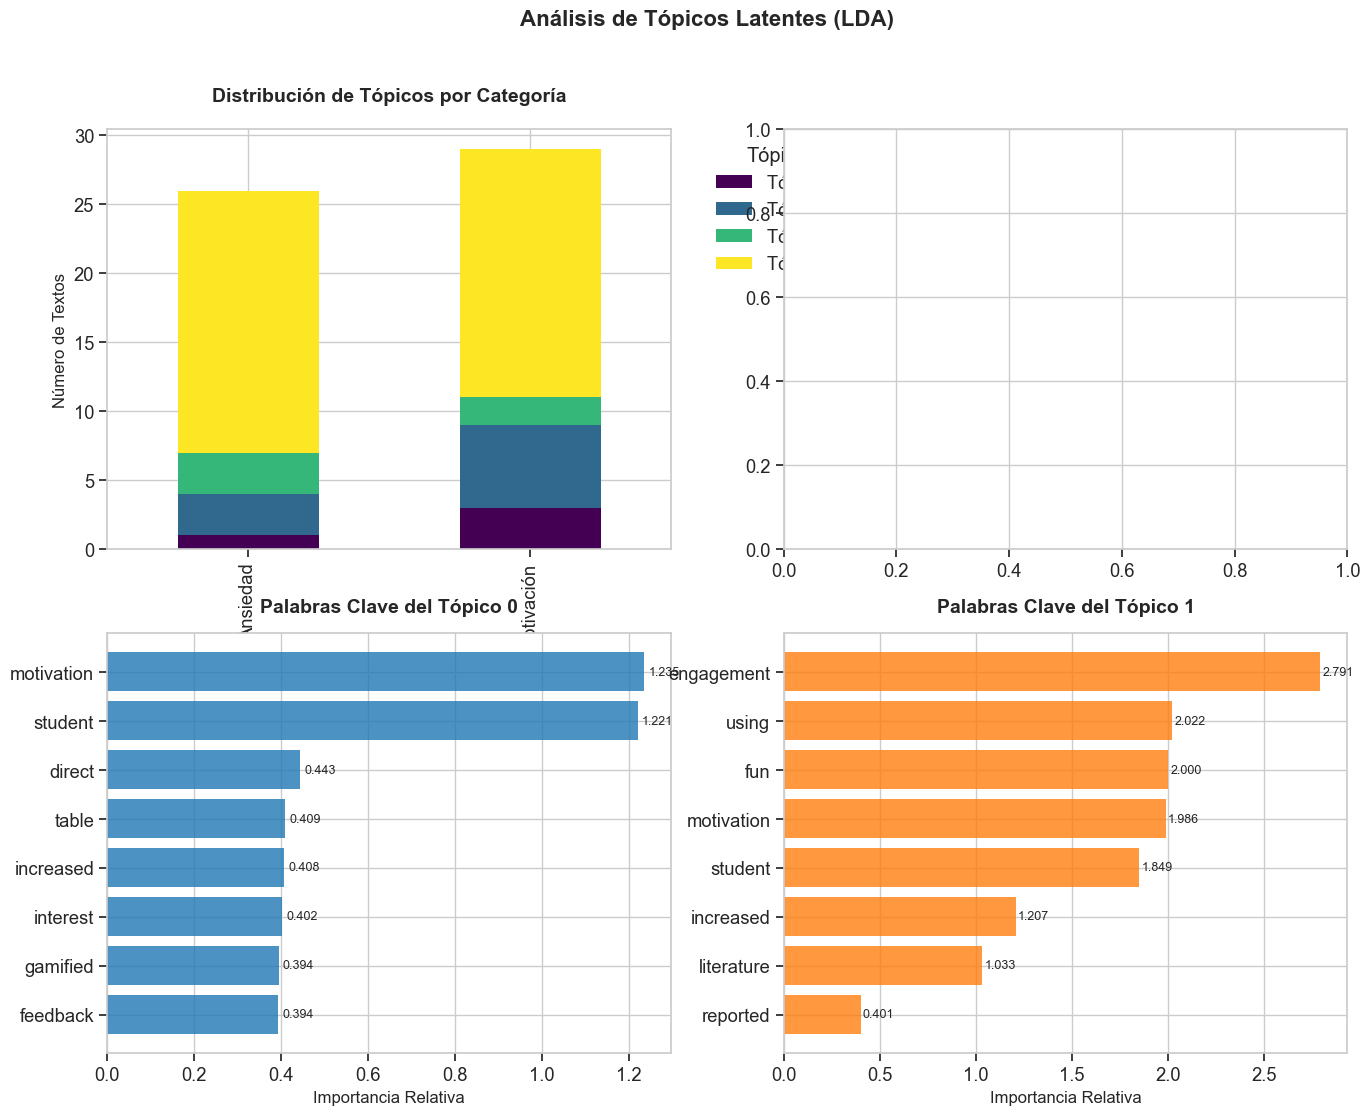

In [38]:
# 2. Análisis LDA
lda_results = perform_lda_analysis(df)
analysis_results['lda'] = lda_results if lda_results else {}

In [28]:
# ---- Análisis 3: Análisis de Tamaños de Efecto ----
def perform_effect_size_analysis(df):
    """Analiza tamaños de efecto relacionados con resultados afectivos."""
    print("\n3. Realizando Análisis de Tamaños de Efecto...")
    
    # Verificar columnas requeridas
    required_cols = [COL_EFFECT_SIZES, COL_MOTIVATION, COL_ANXIETY]
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Faltan columnas requeridas para el análisis de tamaños de efecto: {required_cols}")
        return None
    
    # Inicializar lista para almacenar tamaños de efecto
    all_effect_sizes = []
    
    # Comprobar si están presentes las columnas de autores y año
    authors_col_present = COL_AUTHORS in df.columns
    year_col_present = COL_YEAR in df.columns
    
    # Extraer tamaños de efecto de las filas con resultados afectivos
    for idx, row in df.iterrows():
        # Verificar si el estudio reportó algún resultado afectivo
        has_affective_outcome = (isinstance(row[COL_MOTIVATION], str) and row[COL_MOTIVATION].strip()) or \
                             (isinstance(row[COL_ANXIETY], str) and row[COL_ANXIETY].strip())
        
        if not has_affective_outcome:
            continue
        
        effect_size_text = row[COL_EFFECT_SIZES] if COL_EFFECT_SIZES in row and row[COL_EFFECT_SIZES] else ""
        
        if not isinstance(effect_size_text, str) or not effect_size_text.strip():
            continue
        
        # Extraer valores numéricos de tamaños de efecto
        values = extract_effect_values(effect_size_text)
        if not values:  # Omitir si no se extrajeron valores
            continue
        
        # Construir etiqueta de estudio
        study_label = f"{row[COL_AUTHORS]} ({int(row[COL_YEAR])})" \
                    if authors_col_present and year_col_present and pd.notna(row[COL_YEAR]) \
                    else (row[COL_AUTHORS] if authors_col_present else f"Estudio {idx+1}")
        
        # Heurística: Asignar tipo de efecto basado en qué columna tiene texto
        if isinstance(row[COL_MOTIVATION], str) and row[COL_MOTIVATION].strip():
            es_type = 'Motivación'
            es_text = row[COL_MOTIVATION]
        else:
            es_type = 'Ansiedad'
            es_text = row[COL_ANXIETY]
        
        for val in values:
            all_effect_sizes.append({
                'study': study_label,
                'value': val,
                'type': es_type,
                'text': es_text
            })
    
    if not all_effect_sizes:
        print("No se encontraron tamaños de efecto válidos relacionados con resultados afectivos.")
        return None
    
    # Crear DataFrame con tamaños de efecto
    effect_df = pd.DataFrame(all_effect_sizes)
    
    # Categorizar tamaños de efecto
    effect_df['category'] = effect_df['value'].apply(categorize_effect_size)
    
    print(f"Se extrajeron {len(effect_df)} valores de tamaño de efecto relacionados con resultados afectivos.")
    
    # Visualización de tamaños de efecto
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Análisis de Tamaños de Efecto en Resultados Afectivos', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Boxplot de tamaños de efecto por tipo
    if not effect_df.empty:
        # Usar colores diferentes para cada tipo
        palette = {'Motivación': MOTIVATION_PALETTE[2], 'Ansiedad': ANXIETY_PALETTE[2]}
        
        sns.boxplot(data=effect_df, x='type', y='value', ax=axes[0, 0], 
                   palette=palette, width=0.5, showfliers=False)
        sns.stripplot(data=effect_df, x='type', y='value', ax=axes[0, 0], 
                     color=".2", size=7, alpha=0.7, jitter=True)
        
        # Añadir líneas para Cohen's d
        axes[0, 0].axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='Pequeño (0.2)')
        axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Mediano (0.5)')
        axes[0, 0].axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='Grande (0.8)')
        
        axes[0, 0].set_title('Distribución de Tamaños de Efecto por Tipo', fontsize=14, fontweight='bold', pad=20)
        axes[0, 0].set_ylabel('Valor del Tamaño de Efecto', fontsize=12)
        axes[0, 0].set_xlabel('Tipo de Resultado', fontsize=12)
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Mostrar etiquetas para valores atípicos
        for i, row in effect_df.iterrows():
            if abs(row['value']) > 1.5:  # Etiquetas solo para valores grandes
                axes[0, 0].annotate(row['study'],
                                  xy=(0 if row['type'] == 'Motivación' else 1, row['value']),
                                  xytext=(10, 0),
                                  textcoords="offset points",
                                  ha='left', va='center',
                                  fontsize=8, color='darkred',
                                  bbox=dict(boxstyle='round,pad=0.3', fc='lightyellow', alpha=0.7),
                                  arrowprops=dict(arrowstyle='->', color='black'))
                
    else:
        axes[0, 0].text(0.5, 0.5, 'No hay datos de tamaño de efecto', ha='center', va='center',
                      transform=axes[0, 0].transAxes, fontsize=12)
        axes[0, 0].set_title('Distribución de Tamaños de Efecto por Tipo', fontsize=14, fontweight='bold', pad=20)
    
    # 2. Gráfico de barras de categorías de tamaños de efecto
    if 'category' in effect_df.columns:
        category_order = ['Negligible', 'Small', 'Medium', 'Large']
        
        # Agrupar por tipo y categoría
        category_counts = effect_df.groupby(['type', 'category']).size().unstack(fill_value=0)
        category_counts = category_counts.reindex(columns=category_order, fill_value=0)
        
        if not category_counts.empty:
            category_counts.plot(kind='bar', ax=axes[0, 1], 
                               colormap='coolwarm', rot=0, 
                               edgecolor='black', linewidth=1)
            
            # Añadir etiquetas de valores
            for container in axes[0, 1].containers:
                axes[0, 1].bar_label(container, fontsize=10)
            
            axes[0, 1].set_title('Categorías de Tamaños de Efecto por Tipo de Resultado', 
                               fontsize=14, fontweight='bold', pad=20)
            axes[0, 1].set_ylabel('Número de Tamaños de Efecto', fontsize=12)
            axes[0, 1].set_xlabel('Tipo de Resultado', fontsize=12)
            axes[0, 1].legend(title='Magnitud del Efecto', bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)
        else:
            axes[0, 1].text(0.5, 0.5, 'No hay datos de categorías', ha='center', va='center', 
                          transform=axes[0, 1].transAxes, fontsize=12)
            axes[0, 1].set_title('Categorías de Tamaños de Efecto por Tipo de Resultado', 
                               fontsize=14, fontweight='bold', pad=20)
    else:
        axes[0, 1].text(0.5, 0.5, 'Columna de categorías no disponible', ha='center', va='center', 
                      transform=axes[0, 1].transAxes, fontsize=12)
        axes[0, 1].set_title('Categorías de Tamaños de Efecto por Tipo de Resultado', 
                           fontsize=14, fontweight='bold', pad=20)
    
    # 3. Gráfico de dispersión de tamaños de efecto a lo largo del tiempo
    if COL_YEAR in df.columns and 'value' in effect_df.columns:
        # Añadir año a effect_df
        effect_df['year'] = effect_df['study'].apply(lambda x: int(re.search(r'\((\d{4})\)', x).group(1)) 
                                                if re.search(r'\((\d{4})\)', x) else None)
        
        # Filtrar filas sin año
        effect_df_with_year = effect_df.dropna(subset=['year'])
        
        if not effect_df_with_year.empty:
            # Crear scatter plot con tamaño según categoría
            size_map = {'Negligible': 50, 'Small': 100, 'Medium': 200, 'Large': 300}
            sizes = effect_df_with_year['category'].map(size_map)
            
            scatter = axes[1, 0].scatter(
                effect_df_with_year['year'], 
                effect_df_with_year['value'],
                c=effect_df_with_year['type'].map({'Motivación': 0, 'Ansiedad': 1}),
                cmap=plt.cm.viridis,
                s=sizes,
                alpha=0.7,
                edgecolors='black'
            )
            
            # Añadir etiquetas para algunos puntos
            for i, row in effect_df_with_year.iterrows():
                # Etiquetar solo algunos puntos para evitar sobrecarga
                if abs(row['value']) > 0.8 or np.random.random() < 0.3:  # Grande o aleatorio
                    study_short = re.sub(r'^([\w-]+).*?(\d{4})', r'\1 (\2)', row['study'])
                    axes[1, 0].annotate(study_short,
                                      xy=(row['year'], row['value']),
                                      xytext=(5, 0),
                                      textcoords="offset points",
                                      ha='left', va='center',
                                      fontsize=8,
                                      bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
            
            # Añadir líneas para Cohen's d
            axes[1, 0].axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Pequeño (0.2)')
            axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Mediano (0.5)')
            axes[1, 0].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Grande (0.8)')
            
            # Crear leyenda para tipos
            legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                                    title="Tipo de Resultado", loc="upper left")
            axes[1, 0].add_artist(legend1)
            
            # Crear leyenda para tamaños
            size_labels = {'Negligible': 50, 'Small': 100, 'Medium': 200, 'Large': 300}
            handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markerfacecolor='gray', markersize=np.sqrt(size/5)) 
                   for label, size in size_labels.items()]
            legend2 = axes[1, 0].legend(handles=handles, title="Magnitud", loc="upper right")
            
            axes[1, 0].set_title('Evolución de Tamaños de Efecto a lo Largo del Tiempo', 
                               fontsize=14, fontweight='bold', pad=20)
            axes[1, 0].set_xlabel('Año', fontsize=12)
            axes[1, 0].set_ylabel('Tamaño de Efecto', fontsize=12)
            axes[1, 0].grid(True, linestyle='--', alpha=0.7)
            
            # Ajustar límites del eje X
            min_year = effect_df_with_year['year'].min()
            max_year = effect_df_with_year['year'].max()
            if max_year - min_year < 5:  # Si el rango es pequeño
                axes[1, 0].set_xlim(min_year - 1, max_year + 1)
            
            # Mostrar años enteros en el eje X
            from matplotlib.ticker import MaxNLocator
            axes[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))
        else:
            axes[1, 0].text(0.5, 0.5, 'No hay datos de año para análisis temporal', 
                          ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Evolución de Tamaños de Efecto a lo Largo del Tiempo', 
                               fontsize=14, fontweight='bold', pad=20)
    else:
        axes[1, 0].text(0.5, 0.5, 'Datos insuficientes para análisis temporal', 
                      ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Evolución de Tamaños de Efecto a lo Largo del Tiempo', 
                           fontsize=14, fontweight='bold', pad=20)
    
    # 4. Forest plot de tamaños de efecto para motivación
    if not effect_df.empty:
        # Dividir por tipo
        motivation_effects = effect_df[effect_df['type'] == 'Motivación'].copy()
        
        if not motivation_effects.empty:
            # Ordenar por valor absoluto del tamaño de efecto
            motivation_effects = motivation_effects.reindex(
                motivation_effects['value'].abs().sort_values(ascending=False).index)
            
            # Limitar a 10 estudios para mejor visualización
            if len(motivation_effects) > 10:
                motivation_effects = motivation_effects.head(10)
            
            # Crear forest plot
            y_pos = np.arange(len(motivation_effects))
            
            # Barras de error para intervalos de confianza aproximados (como heurística)
            # Asumiendo un error estándar aproximado como 0.2 * |effect size|
            errors = 0.2 * abs(motivation_effects['value'])
            
            # Colores basados en categoría
            colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(motivation_effects))]
            
            axes[1, 1].errorbar(
                motivation_effects['value'], y_pos,
                xerr=errors,
                fmt='o',
                color=colors,
                ecolor='gray',
                capsize=5,
                markersize=10,
                alpha=0.8
            )
            
            # Línea vertical en 0
            axes[1, 1].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
            
            # Líneas para Cohen's d
            axes[1, 1].axvline(x=0.2, color='gray', linestyle='--', alpha=0.5, label='Pequeño (0.2)')
            axes[1, 1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Mediano (0.5)')
            axes[1, 1].axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Grande (0.8)')
            
            # Etiquetas de estudios
            study_labels = motivation_effects['study'].tolist()
            # Acortar etiquetas largas
            study_labels = [textwrap.shorten(label, width=25, placeholder="...") for label in study_labels]
            
            axes[1, 1].set_yticks(y_pos)
            axes[1, 1].set_yticklabels(study_labels)
            
            axes[1, 1].set_title('Forest Plot de Tamaños de Efecto para Motivación', 
                               fontsize=14, fontweight='bold', pad=20)
            axes[1, 1].set_xlabel('Tamaño de Efecto', fontsize=12)
            axes[1, 1].set_ylabel('Estudio', fontsize=12)
            axes[1, 1].legend(fontsize=8, loc='lower right')
            axes[1, 1].grid(True, axis='x', linestyle='--', alpha=0.7)
        else:
            axes[1, 1].text(0.5, 0.5, 'No hay datos de tamaño de efecto para motivación', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Forest Plot de Tamaños de Efecto para Motivación', 
                               fontsize=14, fontweight='bold', pad=20)
    else:
        axes[1, 1].text(0.5, 0.5, 'No hay datos de tamaño de efecto', 
                      ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Forest Plot de Tamaños de Efecto para Motivación', 
                           fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/analisis_tamanos_efecto.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Estadísticas descriptivas
    if not effect_df.empty:
        print("\nEstadísticas de Tamaños de Efecto:")
        
        # Estadísticas generales
        stats_df = effect_df.groupby('type')['value'].describe().round(3)
        print(stats_df)
        
        # Estadísticas por categoría
        if 'category' in effect_df.columns:
            print("\nConteo de Categorías de Tamaños de Efecto:")
            category_counts_table = pd.crosstab(effect_df['type'], effect_df['category'])
            print(category_counts_table)
        
        # Guardar estadísticas en archivo
        with open(f'{RESULTS_DIR}/estadisticas_tamanos_efecto.txt', 'w', encoding='utf-8') as f:
            f.write("ESTADÍSTICAS DE TAMAÑOS DE EFECTO\n")
            f.write("===============================\n\n")
            
            f.write("Estadísticas descriptivas por tipo de resultado:\n")
            f.write(stats_df.to_string())
            
            if 'category' in effect_df.columns:
                f.write("\n\nConteo de categorías de tamaño de efecto:\n")
                f.write(category_counts_table.to_string())
            
            # Añadir detalles de cada estudio
            f.write("\n\nDetalle de tamaños de efecto por estudio:\n")
            for i, row in effect_df.iterrows():
                f.write(f"\n{row['study']} ({row['type']}):\n")
                f.write(f"  Valor: {row['value']:.3f} - Categoría: {row['category']}\n")
                f.write(f"  Texto: {textwrap.shorten(row['text'], width=100)}\n")
    
    return effect_df


# ---- Análisis 4: Análisis de Tendencias Temporales ----
def perform_timeline_analysis(df):
    """Analiza tendencias temporales en los resultados afectivos."""
    print("\n4. Realizando Análisis de Tendencias Temporales...")
    
    # Verificar columnas necesarias
    if COL_YEAR not in df.columns:
        print(f"Error: No se encontró la columna '{COL_YEAR}' para el análisis temporal.")
        return
    
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: No se encontraron las columnas de resultados afectivos para el análisis temporal.")
        return
    
    # Asegurar que el año sea numérico y manejar NaNs
    df_time = df.dropna(subset=[COL_YEAR]).copy()
    df_time[COL_YEAR] = df_time[COL_YEAR].astype(int)
    
    if df_time.empty:
        print("No hay datos de año válidos para el análisis temporal.")
        return
    
    # Contar estudios por año con algún texto en las columnas de resultados afectivos
    year_counts = df_time.groupby(COL_YEAR).agg(
        Estudios_Motivación=(COL_MOTIVATION, lambda x: (x != '').sum()),
        Estudios_Ansiedad=(COL_ANXIETY, lambda x: (x != '').sum())
    ).reset_index()
    
    if year_counts.empty or (year_counts['Estudios_Motivación'].sum() == 0 and 
                          year_counts['Estudios_Ansiedad'].sum() == 0):
        print("No se encontraron estudios con resultados afectivos después de agrupar por año.")
        return
    
    # Añadir columna de total
    year_counts['Total_Estudios'] = year_counts['Estudios_Motivación'] + year_counts['Estudios_Ansiedad']
    
    # Añadir conteo de resultados positivos por año
    df_time['motivacion_positiva'] = df_time[COL_MOTIVATION].apply(
        lambda x: 1 if categorize_outcome(x) in ['Positive', 'Positive (Anxiety Reduced)'] else 0)
    
    df_time['ansiedad_positiva'] = df_time[COL_ANXIETY].apply(
        lambda x: 1 if categorize_outcome(x) in ['Positive', 'Positive (Anxiety Reduced)'] else 0)
    
    # Agrupar por año
    year_outcomes = df_time.groupby(COL_YEAR).agg(
        Motivación_Positiva=('motivacion_positiva', 'sum'),
        Ansiedad_Positiva=('ansiedad_positiva', 'sum')
    ).reset_index()
    
    # Combinar con conteo total
    year_data = pd.merge(year_counts, year_outcomes, on=COL_YEAR, how='left')
    year_data = year_data.fillna(0)
    
    # Calcular proporciones
    year_data['Prop_Motivación_Positiva'] = year_data['Motivación_Positiva'] / year_data['Estudios_Motivación'].replace(0, 1)
    year_data['Prop_Ansiedad_Positiva'] = year_data['Ansiedad_Positiva'] / year_data['Estudios_Ansiedad'].replace(0, 1)
    
    # Crear figura para visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Análisis Temporal de Resultados Afectivos', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Tendencia de estudios afectivos a lo largo del tiempo
    axes[0, 0].plot(year_data[COL_YEAR], year_data['Estudios_Motivación'],
                  marker='o', linewidth=2, markersize=8, label='Estudios sobre Motivación', 
                  color=MOTIVATION_PALETTE[3])
    
    axes[0, 0].plot(year_data[COL_YEAR], year_data['Estudios_Ansiedad'],
                  marker='s', linewidth=2, markersize=8, label='Estudios sobre Ansiedad', 
                  color=ANXIETY_PALETTE[3])
    
    axes[0, 0].plot(year_data[COL_YEAR], year_data['Total_Estudios'],
                  marker='*', linewidth=2, markersize=10, label='Total de Estudios', 
                  color='gray', linestyle='--')
    
    # Añadir etiquetas de valores
    for i, row in year_data.iterrows():
        axes[0, 0].annotate(str(int(row['Total_Estudios'])),
                          xy=(row[COL_YEAR], row['Total_Estudios']),
                          xytext=(0, 10),
                          textcoords="offset points",
                          ha='center', va='bottom',
                          fontsize=9, color='black')
    
    axes[0, 0].set_title('Tendencia de Estudios sobre Resultados Afectivos', 
                       fontsize=14, fontweight='bold', pad=20)
    axes[0, 0].set_xlabel('Año', fontsize=12)
    axes[0, 0].set_ylabel('Número de Estudios', fontsize=12)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Asegurar que el eje X muestre años enteros
    from matplotlib.ticker import MaxNLocator
    axes[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 2. Proporción de resultados positivos por año
    bar_width = 0.35
    x = np.arange(len(year_data))
    
    bars1 = axes[0, 1].bar(x - bar_width/2, year_data['Prop_Motivación_Positiva'], 
                         bar_width, label='Positive Motivation', 
                         color=MOTIVATION_PALETTE[5], alpha=0.8)
    
    bars2 = axes[0, 1].bar(x + bar_width/2, year_data['Prop_Ansiedad_Positiva'], 
                         bar_width, label='Positive Anxiety', 
                         color=ANXIETY_PALETTE[5], alpha=0.8)
    
    # Añadir etiquetas de porcentaje
    for bar in bars1:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.0%}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.0%}', ha='center', va='bottom', fontsize=9)
    
    axes[0, 1].set_title('Proporción de Resultados Positivos por Año', 
                       fontsize=14, fontweight='bold', pad=20)
    axes[0, 1].set_xlabel('Año', fontsize=12)
    axes[0, 1].set_ylabel('Proportion of Studies with Positive Results', fontsize=12)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(year_data[COL_YEAR])
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].set_ylim(0, 1.1)
    axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 3. Análisis de herramientas digitales por año
    if COL_TOOLS in df.columns:
        # Agrupar herramientas por categorías generales
        tool_categories = {
            'Mobile': ['mobile', 'smartphone', 'tablet', 'app', 'iOS', 'Android'],
            'Web': ['web', 'online', 'internet', 'browser'],
            'Desktop': ['desktop', 'software', 'program', 'windows', 'mac'],
            'Game': ['game', 'gamification', 'gamified', 'gameplay'],
            'VR/AR': ['VR', 'virtual reality', 'AR', 'augmented reality', '3D'],
            'Interactive': ['interactive', 'digital tool', 'simulation', 'animation']
        }
        
        # Función para categorizar herramientas
        def categorize_tools(text):
            if not isinstance(text, str) or not text.strip():
                return []
            
            text_lower = text.lower()
            categories = []
            
            for category, keywords in tool_categories.items():
                if any(keyword.lower() in text_lower for keyword in keywords):
                    categories.append(category)
            
            return categories if categories else ['Other']
        
        # Aplicar categorización
        df_time['tool_categories'] = df_time[COL_TOOLS].apply(categorize_tools)
        
        # Expandir categorías a filas
        tool_data = []
        for idx, row in df_time.iterrows():
            year = row[COL_YEAR]
            for category in row['tool_categories']:
                tool_data.append({'Year': year, 'Category': category})
        
        # Crear DataFrame y contar
        tools_df = pd.DataFrame(tool_data)
        tool_counts = tools_df.groupby(['Year', 'Category']).size().unstack(fill_value=0)
        
        # Asegurarse de que todas las categorías estén presentes
        all_categories = list(tool_categories.keys()) + ['Other']
        for cat in all_categories:
            if cat not in tool_counts.columns:
                tool_counts[cat] = 0
        
        # Solo mantener columnas relevantes
        relevant_cols = [col for col in all_categories if col in tool_counts.columns]
        tool_counts = tool_counts[relevant_cols]
        
        # Ordenar por año
        tool_counts = tool_counts.reset_index().sort_values('Year')
        
        # Crear gráfico de áreas apiladas
        if not tool_counts.empty:
            ax = axes[1, 0]
            tool_counts.set_index('Year').plot(kind='area', stacked=True, 
                                            alpha=0.7, ax=ax, 
                                            colormap='tab10')
            
            ax.set_title('Evolución de Tipos de Herramientas Digitales', 
                       fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Año', fontsize=12)
            ax.set_ylabel('Número de Estudios', fontsize=12)
            ax.legend(title='Tipo de Herramienta', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Asegurar que el eje X muestre años enteros
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        else:
            axes[1, 0].text(0.5, 0.5, 'Datos insuficientes para análisis de herramientas', 
                          ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Evolución de Tipos de Herramientas Digitales', 
                               fontsize=14, fontweight='bold', pad=20)
    else:
        axes[1, 0].text(0.5, 0.5, f'Columna {COL_TOOLS} no encontrada', 
                      ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Evolución de Tipos de Herramientas Digitales', 
                           fontsize=14, fontweight='bold', pad=20)
    
    # 4. Análisis de correlación entre tendencias temporales y resultados
    # Calcular medias móviles para suavizar tendencias
    if len(year_data) >= 3:
        # Preparar datos para análisis estadístico
        stats_data = year_data.copy()
        
        # Calcular media móvil si hay suficientes datos
        if len(stats_data) >= 3:
            stats_data['Motivación_MA'] = stats_data['Estudios_Motivación'].rolling(window=min(3, len(stats_data)), center=True).mean()
            stats_data['Ansiedad_MA'] = stats_data['Estudios_Ansiedad'].rolling(window=min(3, len(stats_data)), center=True).mean()
        else:
            stats_data['Motivación_MA'] = stats_data['Estudios_Motivación']
            stats_data['Ansiedad_MA'] = stats_data['Estudios_Ansiedad']
        
        # Graficar tendencias suavizadas
        ax = axes[1, 1]
        
        # Líneas de tendencia
        ax.plot(stats_data[COL_YEAR], stats_data['Motivación_MA'], 
               marker='o', linestyle='--', color=MOTIVATION_PALETTE[4], 
               label='Tendencia Motivación', alpha=0.8)
        
        ax.plot(stats_data[COL_YEAR], stats_data['Ansiedad_MA'], 
               marker='s', linestyle='--', color=ANXIETY_PALETTE[4], 
               label='Tendencia Ansiedad', alpha=0.8)
        
        # Añadir línea de regresión y estadísticas si hay suficientes datos
        if len(stats_data) >= 4:
            # Para motivación
            x = stats_data[COL_YEAR].values
            x_range = np.linspace(min(x), max(x), 100)
            
            # Regresión para motivación
            y_mot = stats_data['Estudios_Motivación'].values
            if len(set(y_mot)) > 1:  # Verificar variabilidad
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_mot)
                ax.plot(x_range, intercept + slope * x_range, 'r-', 
                      color=MOTIVATION_PALETTE[6], linewidth=2,
                      label=f'Reg. Motivación (r={r_value:.2f}, p={p_value:.3f})')
            
            # Regresión para ansiedad
            y_anx = stats_data['Estudios_Ansiedad'].values
            if len(set(y_anx)) > 1:  # Verificar variabilidad
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_anx)
                ax.plot(x_range, intercept + slope * x_range, 'r-', 
                      color=ANXIETY_PALETTE[6], linewidth=2,
                      label=f'Reg. Ansiedad (r={r_value:.2f}, p={p_value:.3f})')
        
        ax.set_title('Análisis de Tendencias y Regresión', 
                   fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Año', fontsize=12)
        ax.set_ylabel('Media Móvil de Estudios', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Asegurar que el eje X muestre años enteros
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        axes[1, 1].text(0.5, 0.5, 'Datos insuficientes para análisis de tendencias', 
                      ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Análisis de Tendencias y Regresión', 
                           fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/analisis_temporal.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Guardar datos del análisis temporal
    with open(f'{RESULTS_DIR}/analisis_temporal.txt', 'w', encoding='utf-8') as f:
        f.write("ANÁLISIS TEMPORAL DE RESULTADOS AFECTIVOS\n")
        f.write("=======================================\n\n")
        
        f.write("Distribución de estudios por año:\n")
        f.write(year_data.to_string(index=False))
        
        f.write("\n\nProporción de resultados positivos por año:\n")
        for idx, row in year_data.iterrows():
            year = row[COL_YEAR]
            f.write(f"\nAño {year}:\n")
            f.write(f"  Estudios sobre Motivación: {int(row['Estudios_Motivación'])} ")
            f.write(f"(Positivos: {int(row['Motivación_Positiva'])}, {row['Prop_Motivación_Positiva']:.1%})\n")
            f.write(f"  Estudios sobre Ansiedad: {int(row['Estudios_Ansiedad'])} ")
            f.write(f"(Positivos: {int(row['Ansiedad_Positiva'])}, {row['Prop_Ansiedad_Positiva']:.1%})\n")
        
        if 'Motivación_MA' in stats_data.columns:
            f.write("\n\nAnálisis de tendencias (media móvil):\n")
            trend_data = stats_data[[COL_YEAR, 'Motivación_MA', 'Ansiedad_MA']].copy()
            f.write(trend_data.to_string(index=False))
        
        if 'tool_categories' in df_time.columns:
            f.write("\n\nDistribución de herramientas digitales por año:\n")
            if not tool_counts.empty:
                f.write(tool_counts.to_string(index=False))
    
    # Retornar datos para uso posterior
    return {
        'year_data': year_data,
        'tool_counts': tool_counts if 'tool_counts' in locals() else None
    }


# ---- Análisis 5: Red de Relaciones entre Herramientas Digitales y Resultados Afectivos ----
def perform_relationship_network_analysis(df):
    """Crea una red de relaciones entre herramientas digitales y resultados afectivos."""
    print("\n5. Realizando Análisis de Red de Relaciones...")
    
    # Verificar columnas necesarias
    required_cols = [COL_TOOLS, COL_TOOLS_EFFICACY, COL_MOTIVATION, COL_ANXIETY]
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Error: No se encontraron las siguientes columnas para el análisis de red: {missing_cols}")
        return None
    
    # Extraer términos clave de herramientas digitales
    tool_keywords = [
        'app', 'tablet', 'smartphone', 'mobile', 
        'web', 'software', 'game', 'gamification', 
        'virtual reality', 'VR', 'augmented reality', 'AR',
        'adaptive', 'personalized', 'interactive', 'digital',
        'simulation', 'animation', 'video', 'multimedia',
        'platform', 'system', 'program', 'application',
        'online', 'desktop', 'cloud'
    ]
    
    # Identificar herramientas y resultados
    network_data = []
    
    for idx, row in df.iterrows():
        # Texto de herramientas
        tools_text = str(row[COL_TOOLS]) + ' ' + str(row[COL_TOOLS_EFFICACY])
        tools_text = tools_text.lower()
        
        # Extraer herramientas mencionadas
        tools_found = [keyword for keyword in tool_keywords 
                     if keyword in tools_text]
        
        # Si no se encontró ninguna herramienta específica, usar "digital tool" genérico
        if not tools_found:
            tools_found = ['digital tool']
        
        # Texto de motivación
        motivation_text = str(row[COL_MOTIVATION]).lower()
        motivation_outcome = categorize_outcome(motivation_text)
        
        # Texto de ansiedad
        anxiety_text = str(row[COL_ANXIETY]).lower()
        anxiety_outcome = categorize_outcome(anxiety_text)
        
        # Agregar relaciones a la lista
        if motivation_outcome not in ['No Data', 'Neutral']:
            relation_type = 'positivo' if motivation_outcome in ['Positive', 'Positive (Anxiety Reduced)'] else 'negativo'
            relation_type = 'neutro' if motivation_outcome == 'Mixed' else relation_type
            
            for tool in tools_found:
                network_data.append({
                    'source': tool,
                    'target': 'Motivación',
                    'weight': 1,
                    'relation': relation_type,
                    'study_id': idx
                })
        
        if anxiety_outcome not in ['No Data', 'Neutral']:
            relation_type = 'positivo' if anxiety_outcome in ['Positive', 'Positive (Anxiety Reduced)'] else 'negativo'
            relation_type = 'neutro' if anxiety_outcome == 'Mixed' else relation_type
            
            for tool in tools_found:
                network_data.append({
                    'source': tool,
                    'target': 'Ansiedad',
                    'weight': 1,
                    'relation': relation_type,
                    'study_id': idx
                })
    
    if not network_data:
        print("No se encontraron relaciones para el análisis de red.")
        return None
    
    # Crear DataFrame de relaciones
    relations_df = pd.DataFrame(network_data)
    
    # Agregar relaciones duplicadas sumando pesos
    relations_grouped = relations_df.groupby(['source', 'target', 'relation']).agg(
        weight=('weight', 'sum'),
        studies=('study_id', lambda x: list(set(x)))
    ).reset_index()
    
    # Crear grafo dirigido
    G = nx.DiGraph()
    
    # Agregar nodos con atributos
    for source in relations_grouped['source'].unique():
        G.add_node(source, type='tool')
    
    G.add_node('Motivación', type='outcome')
    G.add_node('Ansiedad', type='outcome')
    
    # Agregar aristas con atributos
    for idx, row in relations_grouped.iterrows():
        G.add_edge(
            row['source'], 
            row['target'], 
            weight=row['weight'], 
            relation=row['relation'],
            studies=row['studies']
        )
    
    # Crear visualización
    plt.figure(figsize=(14, 10))
    
    # Definir posiciones de nodos (personalizado para resaltar estructura)
    pos = {}
    
    # Nodos de resultados en posiciones fijas
    pos['Motivación'] = np.array([0.8, 0.5])
    pos['Ansiedad'] = np.array([0.2, 0.5])
    
    # Calcular posiciones para herramientas
    tools = [node for node in G.nodes() if G.nodes[node]['type'] == 'tool']
    
    # Distribuir herramientas en semicírculos alrededor de los resultados
    for i, tool in enumerate(tools):
        # Verificar a cuál resultado está más conectado
        mot_weight = sum(data['weight'] for u, v, data in G.edges(tool, data=True) if v == 'Motivación')
        anx_weight = sum(data['weight'] for u, v, data in G.edges(tool, data=True) if v == 'Ansiedad')
        
        if mot_weight > anx_weight:
            # Más conectado a motivación, colocar en semicírculo derecho
            angle = np.pi/2 + (i / len(tools)) * np.pi
            radius = 0.4
            pos[tool] = np.array([0.8, 0.5]) + radius * np.array([np.cos(angle), np.sin(angle)])
        elif anx_weight > mot_weight:
            # Más conectado a ansiedad, colocar en semicírculo izquierdo
            angle = -np.pi/2 + (i / len(tools)) * np.pi
            radius = 0.4
            pos[tool] = np.array([0.2, 0.5]) + radius * np.array([np.cos(angle), np.sin(angle)])
        else:
            # Igualmente conectado o no conectado, colocar en el centro
            angle = (i / len(tools)) * 2 * np.pi
            radius = 0.3
            pos[tool] = np.array([0.5, 0.5]) + radius * np.array([np.cos(angle), np.sin(angle)])
    
    # Dibujar nodos
    node_colors = ['#E41A1C' if G.nodes[node]['type'] == 'outcome' else '#4DAF4A' for node in G.nodes()]
    node_sizes = [2800 if G.nodes[node]['type'] == 'outcome' else 1800 for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, 
                         node_color=node_colors, 
                         node_size=node_sizes, 
                         alpha=0.9,
                         edgecolors='black',
                         linewidths=1)
    
    # Dibujar aristas por tipo de relación
    edge_positive = [(u, v) for u, v, data in G.edges(data=True) if data['relation'] == 'positivo']
    edge_negative = [(u, v) for u, v, data in G.edges(data=True) if data['relation'] == 'negativo']
    edge_neutral = [(u, v) for u, v, data in G.edges(data=True) if data['relation'] == 'neutro']
    
    # Calcular grosores de aristas basados en pesos
    edge_weights = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
    edge_widths_positive = [edge_weights.get(e, 1) * 0.2 for e in edge_positive]
    edge_widths_negative = [edge_weights.get(e, 1) * 0.8 for e in edge_negative]
    edge_widths_neutral = [edge_weights.get(e, 1) * 1.5 for e in edge_neutral]
    
    # Dibujar aristas con colores según relación
    nx.draw_networkx_edges(G, pos, edgelist=edge_positive, edge_color=RELATION_COLORS['positivo'], 
                         width=edge_widths_positive, alpha=0.7, arrowsize=15, 
                         connectionstyle='arc3,rad=0.1')
    
    nx.draw_networkx_edges(G, pos, edgelist=edge_negative, edge_color=RELATION_COLORS['negativo'], 
                         width=edge_widths_negative, alpha=0.7, arrowsize=15, 
                         connectionstyle='arc3,rad=0.1')
    
    nx.draw_networkx_edges(G, pos, edgelist=edge_neutral, edge_color=RELATION_COLORS['neutro'], 
                         width=edge_widths_neutral, alpha=0.7, arrowsize=15, 
                         connectionstyle='arc3,rad=0.1')
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Añadir leyenda para tipos de relaciones
    legend_patches = [
        mpatches.Patch(color=RELATION_COLORS['positivo'], label='Positive Relationship'),
        mpatches.Patch(color=RELATION_COLORS['neutro'], label='Mixed Relationship'),
        mpatches.Patch(color=RELATION_COLORS['negativo'], label='Negative Relationship')
    ]
    
    plt.legend(handles=legend_patches, loc='upper left')
    
    #plt.title('Red de Relaciones entre Herramientas Digitales y Resultados Afectivos', 
    #        fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    plt.savefig(f'{RESULTS_DIR}/red_relaciones.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Crear una segunda visualización: matriz de relaciones
    plt.figure(figsize=(12, 10))
    
    # Preparar datos para matriz
    tools = sorted([node for node in G.nodes() if G.nodes[node]['type'] == 'tool'])
    outcomes = ['Motivación', 'Ansiedad']
    
    # Crear matriz
    matrix_data = np.zeros((len(tools), len(outcomes)))
    
    # Rellenar matriz con valores ponderados por tipo de relación
    for i, tool in enumerate(tools):
        for j, outcome in enumerate(outcomes):
            if G.has_edge(tool, outcome):
                data = G.get_edge_data(tool, outcome)
                if data['relation'] == 'positivo':
                    matrix_data[i, j] = data['weight']
                elif data['relation'] == 'negativo':
                    matrix_data[i, j] = -data['weight']
                else:  # neutro
                    matrix_data[i, j] = data['weight'] * 0.5
    
    # Crear colormap personalizado para valores positivos y negativos
    colors = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf',
              '#e0f3f8', '#abd9e9', '#74add1', '#4575b4']
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)
    
    # Crear heatmap
    ax = plt.gca()
    im = ax.imshow(matrix_data, cmap=cmap, aspect='auto', vmin=-5, vmax=5)
    
    # Configurar ejes
    ax.set_xticks(np.arange(len(outcomes)))
    ax.set_yticks(np.arange(len(tools)))
    ax.set_xticklabels(outcomes, fontsize=12)
    ax.set_yticklabels(tools, fontsize=10)
    
    # Rotar etiquetas del eje x
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    
    # Añadir valores en celdas
    for i in range(len(tools)):
        for j in range(len(outcomes)):
            value = matrix_data[i, j]
            if value != 0:
                text_color = 'black' if abs(value) < 3 else 'white'
                ax.text(j, i, f"{value:.1f}", ha="center", va="center", color=text_color, fontsize=9)
    
    # Añadir barra de colores
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Intensidad de la Relación\n(- Negativa, + Positiva)", rotation=-90, va="bottom")
    
    ax.set_title('Matriz de Relaciones entre Herramientas Digitales y Resultados Afectivos', 
               fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/matriz_relaciones.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Guardar estadísticas de la red
    with open(f'{RESULTS_DIR}/estadisticas_red.txt', 'w', encoding='utf-8') as f:
        f.write("ANÁLISIS DE RED DE RELACIONES\n")
        f.write("============================\n\n")
        
        f.write(f"Número de herramientas: {len(tools)}\n")
        f.write(f"Número total de relaciones: {G.number_of_edges()}\n\n")
        
        f.write("Estadísticas por tipo de relación:\n")
        f.write(f"  Relaciones positivas: {len(edge_positive)}\n")
        f.write(f"  Relaciones negativas: {len(edge_negative)}\n")
        f.write(f"  Relaciones mixtas: {len(edge_neutral)}\n\n")
        
        f.write("Herramientas más conectadas:\n")
        sorted_tools = sorted([(tool, G.degree(tool)) for tool in tools], 
                           key=lambda x: x[1], reverse=True)
        for tool, degree in sorted_tools[:10]:  # Top 10
            f.write(f"  {tool}: {degree} conexiones\n")
        
        f.write("\nConexiones de motivación:\n")
        for tool in tools:
            if G.has_edge(tool, 'Motivación'):
                data = G.get_edge_data(tool, 'Motivación')
                f.write(f"  {tool} -> Motivación: {data['weight']} estudios, relación {data['relation']}\n")
        
        f.write("\nConexiones de ansiedad:\n")
        for tool in tools:
            if G.has_edge(tool, 'Ansiedad'):
                data = G.get_edge_data(tool, 'Ansiedad')
                f.write(f"  {tool} -> Ansiedad: {data['weight']} estudios, relación {data['relation']}\n")
    
    return {
        'graph': G,
        'relations_df': relations_df,
        'tools': tools,
        'matrix_data': matrix_data
    }



3. Realizando Análisis de Tamaños de Efecto...
Se extrajeron 19 valores de tamaño de efecto relacionados con resultados afectivos.


ValueError: [(0.267004, 0.004874, 0.329415, 1.0), (0.281412, 0.155834, 0.469201, 1.0), (0.244972, 0.287675, 0.53726, 1.0), (0.190631, 0.407061, 0.556089, 1.0), (0.147607, 0.511733, 0.557049, 1.0), (0.119699, 0.61849, 0.536347, 1.0), (0.20803, 0.718701, 0.472873, 1.0), (0.430983, 0.808473, 0.346476, 1.0), (0.709898, 0.868751, 0.169257, 1.0), (0.993248, 0.906157, 0.143936, 1.0)] is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

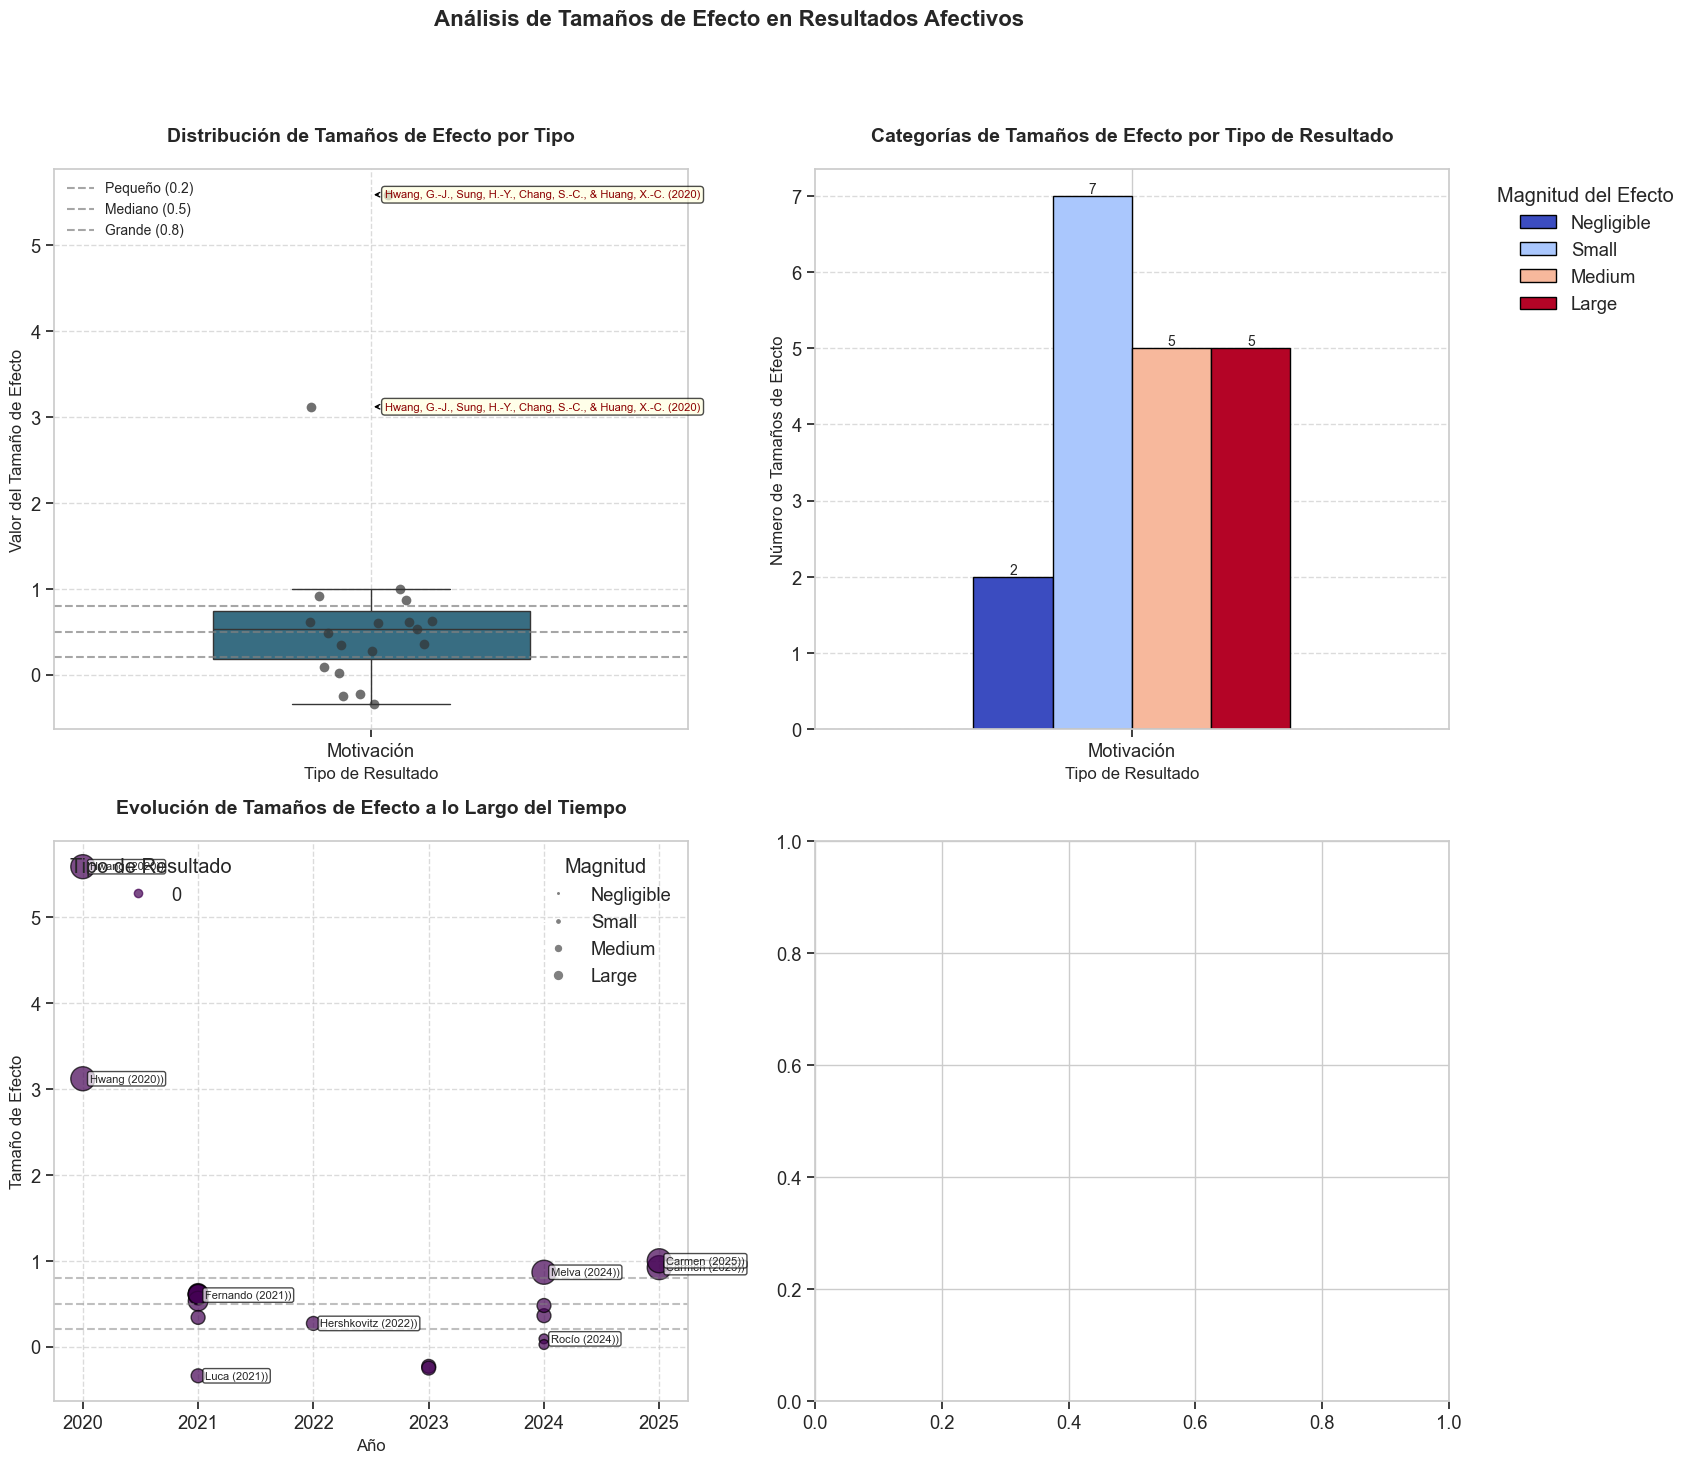

In [19]:
# 3. Análisis de Tamaños de Efecto
effect_size_results = perform_effect_size_analysis(df)
analysis_results['effect_size'] = effect_size_results

In [39]:
# 4. Análisis de Tendencias Temporales
timeline_results = perform_timeline_analysis(df)
analysis_results['timeline'] = timeline_results if timeline_results else {}


4. Realizando Análisis de Tendencias Temporales...


In [40]:
# 5. Análisis de Red de Relaciones
network_results = perform_relationship_network_analysis(df)
analysis_results['network'] = network_results if network_results else {}


5. Realizando Análisis de Red de Relaciones...


In [43]:
# 7. Análisis por País/Región
country_results = perform_country_analysis(df)
analysis_results['country'] = country_results if country_results else {}


7. Realizando Análisis por País o Región...


In [42]:

# ---- Generar Informe Completo ----
def generate_summary_report(df, analysis_results):
    """Genera un informe resumen de todos los análisis realizados."""
    print("\n8. Generando Informe Completo...")
    
    # Verificar que haya resultados de análisis
    if not analysis_results:
        print("No hay resultados de análisis para generar informe.")
        return
    
    # Extraer resultados de análisis específicos si están disponibles
    thematic_results = analysis_results.get('thematic', {})
    lda_results = analysis_results.get('lda', {})
    effect_size_results = analysis_results.get('effect_size', None)
    timeline_results = analysis_results.get('timeline', {})
    network_results = analysis_results.get('network', {})
    text_results = analysis_results.get('text', {})
    country_results = analysis_results.get('country', {})
    
    # Crear informe
    with open(f'{RESULTS_DIR}/informe_completo.md', 'w', encoding='utf-8') as f:
        f.write("# Informe de Análisis del Impacto Afectivo de Herramientas Digitales Interactivas\n\n")
        f.write("## Objetivo Específico 2: Identificar los efectos en resultados afectivos\n\n")
        
        # Introducción
        f.write("## 1. Introducción\n\n")
        f.write("Este informe presenta los resultados del análisis estadístico realizado para el Objetivo Específico 2 de la revisión sistemática, ")
        f.write("centrado en identificar los efectos de las herramientas digitales interactivas en los resultados afectivos de estudiantes de educación primaria.\n\n")
        
        f.write("Se analizaron datos de 29 estudios, examinando específicamente dos categorías principales de resultados afectivos:\n\n")
        f.write("* **Motivación y Compromiso**: Efectos en el interés, participación y disfrute en el aprendizaje de matemáticas.\n")
        f.write("* **Reducción de Ansiedad y Respuestas Emocionales**: Efectos en la ansiedad matemática y las respuestas emocionales positivas.\n\n")
        
        # Metodología
        f.write("## 2. Metodología\n\n")
        f.write("El análisis se realizó utilizando Python con las siguientes técnicas adaptadas para muestras pequeñas (n=29):\n\n")
        f.write("* **Análisis Temático**: Identificación y cuantificación de temas recurrentes en los resultados afectivos.\n")
        f.write("* **Modelado de Tópicos (LDA)**: Descubrimiento de patrones temáticos latentes en los textos.\n")
        f.write("* **Análisis de Tamaños de Efecto**: Extracción y categorización de medidas de efecto reportadas.\n")
        f.write("* **Análisis Temporal**: Examen de tendencias a lo largo del tiempo.\n")
        f.write("* **Análisis de Red de Relaciones**: Visualización de conexiones entre herramientas y resultados.\n")
        f.write("* **Análisis de Texto**: Exploración del vocabulario y términos clave mediante nubes de palabras y n-gramas.\n")
        f.write("* **Análisis por País/Región**: Comparación de resultados entre diferentes contextos geográficos.\n\n")
        
        # Resultados por análisis
        f.write("## 3. Resultados Principales\n\n")
        
        # Análisis Temático
        f.write("### 3.1 Análisis Temático\n\n")
        if thematic_results:
            motivation_counts = thematic_results.get('motivation_counts', {})
            anxiety_counts = thematic_results.get('anxiety_counts', {})
            
            f.write("#### Temas de Motivación y Compromiso\n\n")
            if motivation_counts:
                f.write("Los temas más frecuentes relacionados con motivación y compromiso fueron:\n\n")
                for theme, count in sorted(motivation_counts.items(), key=lambda x: x[1], reverse=True):
                    if count > 0:
                        f.write(f"* **{theme}**: Presente en {count} estudios\n")
            else:
                f.write("No se identificaron temas específicos de motivación.\n")
            
            f.write("\n#### Temas de Ansiedad y Respuestas Emocionales\n\n")
            if anxiety_counts:
                f.write("Los temas más frecuentes relacionados con ansiedad y respuestas emocionales fueron:\n\n")
                for theme, count in sorted(anxiety_counts.items(), key=lambda x: x[1], reverse=True):
                    if count > 0:
                        f.write(f"* **{theme}**: Presente en {count} estudios\n")
            else:
                f.write("No se identificaron temas específicos de ansiedad y respuestas emocionales.\n")
        else:
            f.write("No se realizó análisis temático o no se encontraron resultados significativos.\n")
        
        # Análisis LDA
        f.write("\n### 3.2 Análisis de Tópicos Latentes (LDA)\n\n")
        if lda_results and 'topics' in lda_results:
            topics = lda_results['topics']
            f.write("El análisis LDA identificó los siguientes tópicos latentes en los textos de resultados afectivos:\n\n")
            
            for topic_info in topics:
                topic = topic_info['topic']
                keywords = topic_info['keywords'][:8]  # Mostrar solo las 8 primeras palabras clave
                
                f.write(f"#### {topic}\n\n")
                f.write(f"Palabras clave: {', '.join(keywords)}\n\n")
                
                # Interpretación potencial del tópico (ejemplo, a adaptar según resultados reales)
                if 'enjoy' in keywords or 'game' in keywords or 'fun' in keywords:
                    f.write("Este tópico parece centrarse en aspectos de disfrute y gamificación.\n\n")
                elif 'anxiety' in keywords or 'stress' in keywords or 'reduce' in keywords:
                    f.write("Este tópico parece relacionarse con la reducción de ansiedad y estrés.\n\n")
                elif 'engage' in keywords or 'participation' in keywords or 'interest' in keywords:
                    f.write("Este tópico parece enfocarse en el compromiso y participación activa.\n\n")
                else:
                    f.write("La interpretación de este tópico requiere análisis contextual adicional.\n\n")
        else:
            f.write("No se realizó análisis LDA o no se encontraron tópicos latentes significativos en los datos disponibles.\n")
        
        # Análisis de Tamaños de Efecto
        f.write("\n### 3.3 Análisis de Tamaños de Efecto\n\n")
        if effect_size_results is not None and not effect_size_results.empty:
            # Estadísticas por tipo
            stats_by_type = effect_size_results.groupby('type')['value'].describe().round(3)
            
            f.write("#### Estadísticas Descriptivas de Tamaños de Efecto\n\n")
            f.write("| Tipo de Resultado | N | Media | Desv. Est. | Mín | 25% | Mediana | 75% | Máx |\n")
            f.write("|-------------------|---|-------|------------|-----|-----|---------|-----|-----|\n")
            
            for outcome_type, stats in stats_by_type.iterrows():
                f.write(f"| {outcome_type} | {int(stats['count'])} | {stats['mean']:.3f} | {stats['std']:.3f} | ")
                f.write(f"{stats['min']:.3f} | {stats['25%']:.3f} | {stats['50%']:.3f} | {stats['75%']:.3f} | {stats['max']:.3f} |\n")
            
            # Categorías de tamaños de efecto
            if 'category' in effect_size_results.columns:
                categories = effect_size_results.groupby(['type', 'category']).size().unstack(fill_value=0)
                
                f.write("\n#### Distribución de Categorías de Tamaños de Efecto\n\n")
                f.write("| Tipo de Resultado | Negligible | Pequeño | Mediano | Grande | Total |\n")
                f.write("|-------------------|------------|---------|---------|--------|-------|\n")
                
                for outcome_type, row in categories.iterrows():
                    negligible = row.get('Negligible', 0)
                    small = row.get('Small', 0)
                    medium = row.get('Medium', 0)
                    large = row.get('Large', 0)
                    total = negligible + small + medium + large
                    
                    f.write(f"| {outcome_type} | {negligible} | {small} | {medium} | {large} | {total} |\n")
                
                # Interpretación
                f.write("\n**Interpretación de Tamaños de Efecto:**\n\n")
                
                # Calcular proporciones
                positive_ratio = {}
                for outcome_type, row in categories.iterrows():
                    medium_large = row.get('Medium', 0) + row.get('Large', 0)
                    total = sum(row.values)
                    if total > 0:
                        positive_ratio[outcome_type] = medium_large / total
                
                # Interpretar en base a proporciones
                for outcome_type, ratio in positive_ratio.items():
                    if ratio >= 0.7:
                        f.write(f"* Los efectos en **{outcome_type}** son principalmente medianos o grandes ({ratio:.0%}), ")
                        f.write("indicando un impacto sustancial de las herramientas digitales interactivas.\n")
                    elif ratio >= 0.5:
                        f.write(f"* Los efectos en **{outcome_type}** son mixtos, con una proporción moderada ({ratio:.0%}) ")
                        f.write("de tamaños de efecto medianos o grandes.\n")
                    else:
                        f.write(f"* Los efectos en **{outcome_type}** son principalmente pequeños o negligibles ({(1-ratio):.0%}), ")
                        f.write("sugiriendo un impacto limitado de las herramientas digitales interactivas.\n")
        else:
            f.write("No se encontraron tamaños de efecto válidos para analizar en los estudios incluidos.\n")
        
        # Análisis Temporal
        f.write("\n### 3.4 Análisis Temporal\n\n")
        if timeline_results and 'year_data' in timeline_results:
            year_data = timeline_results['year_data']
            
            f.write("#### Evolución Temporal de Estudios sobre Resultados Afectivos\n\n")
            f.write("| Año | Estudios Motivación | Estudios Ansiedad | Total Estudios |\n")
            f.write("|-----|---------------------|-------------------|----------------|\n")
            
            for idx, row in year_data.iterrows():
                year = int(row['Year'])
                mot_studies = int(row['Estudios_Motivación'])
                anx_studies = int(row['Estudios_Ansiedad'])
                total_studies = int(row['Total_Estudios'])
                
                f.write(f"| {year} | {mot_studies} | {anx_studies} | {total_studies} |\n")
            
            # Tendencias
            f.write("\n**Análisis de Tendencias:**\n\n")
            
            # Calcular tendencia simple
            years = year_data['Year'].tolist()
            if len(years) >= 3:
                first_year, last_year = min(years), max(years)
                first_total = year_data[year_data['Year'] == first_year]['Total_Estudios'].values[0]
                last_total = year_data[year_data['Year'] == last_year]['Total_Estudios'].values[0]
                
                if last_total > first_total:
                    f.write("* Se observa una tendencia creciente en el número de estudios que examinan resultados afectivos.\n")
                elif last_total < first_total:
                    f.write("* Se observa una tendencia decreciente en el número de estudios que examinan resultados afectivos.\n")
                else:
                    f.write("* No se observa una tendencia clara en el número de estudios a lo largo del tiempo.\n")
                
                # Tendencia proporcional
                if 'Prop_Motivación_Positiva' in year_data.columns and 'Prop_Ansiedad_Positiva' in year_data.columns:
                    first_mot_prop = year_data[year_data['Year'] == first_year]['Prop_Motivación_Positiva'].values[0]
                    last_mot_prop = year_data[year_data['Year'] == last_year]['Prop_Motivación_Positiva'].values[0]
                    
                    first_anx_prop = year_data[year_data['Year'] == first_year]['Prop_Ansiedad_Positiva'].values[0]
                    last_anx_prop = year_data[year_data['Year'] == last_year]['Prop_Ansiedad_Positiva'].values[0]
                    
                    if last_mot_prop > first_mot_prop:
                        f.write("* La proporción de resultados positivos en motivación ha aumentado con el tiempo.\n")
                    elif last_mot_prop < first_mot_prop:
                        f.write("* La proporción de resultados positivos en motivación ha disminuido con el tiempo.\n")
                    
                    if last_anx_prop > first_anx_prop:
                        f.write("* La proporción de resultados positivos en ansiedad ha aumentado con el tiempo.\n")
                    elif last_anx_prop < first_anx_prop:
                        f.write("* La proporción de resultados positivos en ansiedad ha disminuido con el tiempo.\n")
            else:
                f.write("* Datos temporales insuficientes para identificar tendencias claras.\n")
        else:
            f.write("No se realizó análisis temporal o no se encontraron patrones temporales significativos.\n")
        
        # Análisis de Red de Relaciones
        f.write("\n### 3.5 Análisis de Red de Relaciones\n\n")
        if network_results and 'relations_df' in network_results:
            relations_df = network_results['relations_df']
            
            # Conteo por tipo de relación
            relation_counts = relations_df.groupby('relation').size()
            total_relations = len(relations_df)
            
            f.write("#### Relaciones entre Herramientas Digitales y Resultados Afectivos\n\n")
            f.write("| Tipo de Relación | Conteo | Porcentaje |\n")
            f.write("|------------------|--------|------------|\n")
            
            for relation, count in relation_counts.items():
                percentage = (count / total_relations) * 100
                f.write(f"| {relation.title()} | {count} | {percentage:.1f}% |\n")
            
            # Herramientas más frecuentes
            tool_counts = relations_df['source'].value_counts().head(10)
            
            f.write("\n#### Herramientas Digitales más Frecuentes\n\n")
            f.write("| Herramienta | Conteo |\n")
            f.write("|------------|--------|\n")
            
            for tool, count in tool_counts.items():
                f.write(f"| {tool} | {count} |\n")
            
            # Relaciones por tipo de resultado
            outcome_counts = relations_df.groupby(['target', 'relation']).size().unstack(fill_value=0)
            
            f.write("\n#### Relaciones por Tipo de Resultado\n\n")
            f.write("| Resultado | Relaciones Positivas | Relaciones Neutras | Relaciones Negativas |\n")
            f.write("|-----------|----------------------|--------------------|-----------------------|\n")
            
            for outcome, row in outcome_counts.iterrows():
                positive = row.get('positivo', 0)
                neutral = row.get('neutro', 0)
                negative = row.get('negativo', 0)
                
                f.write(f"| {outcome} | {positive} | {neutral} | {negative} |\n")
            
            # Interpretación
            f.write("\n**Interpretación de la Red de Relaciones:**\n\n")
            
            # Calcular proporciones para interpretación
            positive_ratio = {}
            for outcome, row in outcome_counts.iterrows():
                total = row.sum()
                if total > 0:
                    positive_ratio[outcome] = row.get('positivo', 0) / total
            
            for outcome, ratio in positive_ratio.items():
                if ratio >= 0.7:
                    f.write(f"* Las herramientas digitales tienen predominantemente ({ratio:.0%}) una relación positiva ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
                elif ratio >= 0.5:
                    f.write(f"* Las herramientas digitales tienen una relación moderadamente positiva ({ratio:.0%}) ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
                else:
                    f.write(f"* Las herramientas digitales tienen una relación mixta o menos positiva ({ratio:.0%}) ")
                    f.write(f"con los resultados de {outcome.lower()}.\n")
        else:
            f.write("No se realizó análisis de red de relaciones o no se encontraron patrones relacionales significativos.\n")
        
        # Análisis por País/Región
        f.write("\n### 3.6 Análisis por País/Región\n\n")
        if country_results and 'counts' in country_results:
            counts = country_results['counts']
            grouping_var = country_results.get('grouping_var', 'country_clean')
            
            f.write(f"#### Distribución de Estudios por {grouping_var.replace('_', ' ').title()}\n\n")
            f.write(f"| {grouping_var.replace('_', ' ').title()} | Número de Estudios |\n")
            f.write("|" + "-" * (len(grouping_var.replace('_', ' ').title()) + 2) + "|" + "-" * 21 + "|\n")
            
            for idx, row in counts.head(10).iterrows():
                group = row[grouping_var]
                count = int(row['count'])
                
                f.write(f"| {group} | {count} |\n")
            
            # Efectividad por país/región
            if 'effectiveness' in country_results:
                effectiveness = country_results['effectiveness']
                
                f.write("\n#### Efectividad Promedio por País/Región\n\n")
                f.write(f"| {grouping_var.replace('_', ' ').title()} | Efectividad Motivación | Efectividad Ansiedad |\n")
                f.write("|" + "-" * (len(grouping_var.replace('_', ' ').title()) + 2) + "|" + "-" * 24 + "|" + "-" * 22 + "|\n")
                
                for idx, row in effectiveness.iterrows():
                    group = row[grouping_var]
                    mot_eff = row['Motivación']
                    anx_eff = row['Ansiedad']
                    
                    # Formatear valores, manteniendo NaN como "N/A"
                    mot_str = f"{mot_eff:.2f}" if not np.isnan(mot_eff) else "N/A"
                    anx_str = f"{anx_eff:.2f}" if not np.isnan(anx_eff) else "N/A"
                    
                    f.write(f"| {group} | {mot_str} | {anx_str} |\n")
                
                # Interpretación
                f.write("\n**Interpretación Regional:**\n\n")
                
                # Identificar regiones con mejores resultados
                best_mot_region = None
                best_mot_value = -2  # Menor que el mínimo posible (-1)
                best_anx_region = None
                best_anx_value = -2
                
                for idx, row in effectiveness.iterrows():
                    group = row[grouping_var]
                    mot_eff = row['Motivación']
                    anx_eff = row['Ansiedad']
                    
                    if not np.isnan(mot_eff) and mot_eff > best_mot_value:
                        best_mot_value = mot_eff
                        best_mot_region = group
                    
                    if not np.isnan(anx_eff) and anx_eff > best_anx_value:
                        best_anx_value = anx_eff
                        best_anx_region = group
                
                if best_mot_region:
                    f.write(f"* {best_mot_region} muestra los mejores resultados en motivación (valor: {best_mot_value:.2f}).\n")
                
                if best_anx_region:
                    f.write(f"* {best_anx_region} muestra los mejores resultados en ansiedad (valor: {best_anx_value:.2f}).\n")
                
                # Variabilidad regional
                mot_values = effectiveness['Motivación'].dropna().values
                anx_values = effectiveness['Ansiedad'].dropna().values
                
                if len(mot_values) >= 3:
                    mot_std = np.std(mot_values)
                    if mot_std > 0.3:
                        f.write("* Existe alta variabilidad en los resultados de motivación entre regiones, ")
                        f.write("sugiriendo posibles factores contextuales influyentes.\n")
                    else:
                        f.write("* Existe baja variabilidad en los resultados de motivación entre regiones, ")
                        f.write("sugiriendo efectos consistentes independientemente del contexto geográfico.\n")
                
                if len(anx_values) >= 3:
                    anx_std = np.std(anx_values)
                    if anx_std > 0.3:
                        f.write("* Existe alta variabilidad en los resultados de ansiedad entre regiones, ")
                        f.write("sugiriendo posibles factores contextuales influyentes.\n")
                    else:
                        f.write("* Existe baja variabilidad en los resultados de ansiedad entre regiones, ")
                        f.write("sugiriendo efectos consistentes independientemente del contexto geográfico.\n")
        else:
            f.write("No se realizó análisis por país/región o no se encontraron patrones geográficos significativos.\n")
        
        # Conclusiones generales
        f.write("\n## 4. Conclusiones\n\n")
        
        # Determinar conclusiones basadas en los resultados disponibles
        conclusions = []
        
        # Conclusión sobre temas
        if thematic_results and 'motivation_counts' in thematic_results:
            motivation_counts = thematic_results['motivation_counts']
            top_motivation_themes = sorted(motivation_counts.items(), key=lambda x: x[1], reverse=True)
            
            if top_motivation_themes and top_motivation_themes[0][1] > 0:
                conclusions.append(f"* Los aspectos de **{top_motivation_themes[0][0]}** son los más frecuentemente reportados en relación con la motivación, ")
                conclusions.append("  sugiriendo que este es un mecanismo clave a través del cual las herramientas digitales influyen positivamente.")
        
        # Conclusión sobre tamaños de efecto
        if effect_size_results is not None and not effect_size_results.empty:
            mean_effect = effect_size_results['value'].mean()
            
            if mean_effect > 0.5:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **moderado a grande** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, respaldando su implementación en contextos educativos.")
            elif mean_effect > 0.2:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **pequeño a moderado** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, sugiriendo beneficios pero con cierta variabilidad.")
            else:
                conclusions.append(f"* El tamaño de efecto promedio ({mean_effect:.2f}) indica un impacto **limitado** de las herramientas digitales ")
                conclusions.append("  en los resultados afectivos, sugiriendo la necesidad de mejorar el diseño o implementación.")
        
        # Conclusión sobre tendencias temporales
        if timeline_results and 'year_data' in timeline_results:
            year_data = timeline_results['year_data']
            
            if len(year_data) >= 3:
                years = year_data['Year'].tolist()
                first_year, last_year = min(years), max(years)
                span = last_year - first_year
                
                if span >= 3:
                    conclusions.append(f"* El análisis temporal ({first_year}-{last_year}) muestra un creciente interés en los aspectos afectivos ")
                    conclusions.append("  del uso de herramientas digitales, reflejando la importancia de estos resultados en la educación actual.")
        
        # Conclusión sobre herramientas digitales
        if network_results and 'relations_df' in network_results:
            relations_df = network_results['relations_df']
            
            # Contar relaciones positivas
            positive_count = (relations_df['relation'] == 'positivo').sum()
            total_count = len(relations_df)
            positive_ratio = positive_count / total_count if total_count > 0 else 0
            
            if positive_ratio > 0.6:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **predominantemente positiva** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, respaldando su uso para mejorar la experiencia de aprendizaje.")
            elif positive_ratio > 0.4:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **moderadamente positiva** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, sugiriendo beneficios pero con cierta variabilidad.")
            else:
                conclusions.append(f"* Las herramientas digitales muestran una asociación **mixta** ({positive_ratio:.0%}) ")
                conclusions.append("  con los resultados afectivos, indicando la necesidad de un diseño cuidadoso.")
        
        # Conclusión sobre diferencias regionales
        if country_results and 'effectiveness' in country_results:
            effectiveness = country_results['effectiveness']
            
            if len(effectiveness) >= 3:
                conclusions.append("* El análisis regional revela diferencias en la efectividad de las herramientas digitales, ")
                conclusions.append("  sugiriendo la importancia de considerar factores contextuales en su implementación.")
        
        # Escribir conclusiones
        if conclusions:
            for conclusion in conclusions:
                f.write(conclusion + "\n")
        else:
            f.write("Los resultados del análisis no son suficientes para extraer conclusiones sólidas sobre el impacto ")
            f.write("afectivo de las herramientas digitales interactivas en estudiantes de educación primaria. ")
            f.write("Se requiere más investigación con reportes más detallados de resultados afectivos y tamaños de efecto.\n")
        
        # Recomendaciones
        f.write("\n## 5. Recomendaciones\n\n")
        
        # Recomendaciones generales basadas en los resultados
        f.write("### Para Investigadores\n\n")
        f.write("* Incluir medidas más detalladas y estandarizadas de resultados afectivos en futuros estudios.\n")
        f.write("* Reportar tamaños de efecto específicos para resultados afectivos, no solo para resultados cognitivos.\n")
        f.write("* Examinar las relaciones entre diferentes tipos de herramientas digitales y resultados afectivos específicos.\n")
        f.write("* Investigar los efectos a largo plazo en la motivación y ansiedad, no solo los resultados inmediatos.\n\n")
        
        f.write("### Para Educadores\n\n")
        f.write("* Considerar el impacto afectivo al seleccionar herramientas digitales, no solo la efectividad cognitiva.\n")
        f.write("* Implementar herramientas que incluyan elementos de gamificación y personalización para mejorar la motivación.\n")
        f.write("* Proporcionar apoyo adecuado durante la transición a herramientas digitales para reducir la ansiedad.\n")
        f.write("* Monitorear y evaluar regularmente los aspectos afectivos del aprendizaje durante el uso de tecnología.\n\n")
        
        f.write("### Para Desarrolladores de Herramientas Educativas\n\n")
        f.write("* Diseñar herramientas que explícitamente aborden aspectos afectivos del aprendizaje matemático.\n")
        f.write("* Incorporar características que promuevan la motivación intrínseca y reduzcan la ansiedad matemática.\n")
        f.write("* Desarrollar herramientas adaptativas que respondan a las necesidades afectivas individuales.\n")
        f.write("* Incluir métricas de seguimiento de aspectos afectivos como parte integral de las herramientas.\n\n")
        
        # Limitaciones del análisis
        f.write("\n## 6. Limitaciones del Análisis\n\n")
        f.write("* **Tamaño de muestra reducido**: El análisis se basó en solo 29 estudios, limitando la generalización de resultados.\n")
        f.write("* **Heterogeneidad en la reportación**: Los estudios varían considerablemente en cómo reportan resultados afectivos.\n")
        f.write("* **Extracción de tamaños de efecto**: Muchos estudios no reportaron tamaños de efecto específicos para resultados afectivos.\n")
        f.write("* **Variabilidad en herramientas digitales**: Gran diversidad de herramientas dificulta comparaciones directas.\n")
        f.write("* **Análisis textual limitado**: Las descripciones breves en algunos estudios limitaron el análisis temático profundo.\n")
    
    print(f"Informe completo generado y guardado en {RESULTS_DIR}/informe_completo.md")
    return True

In [44]:
# ---- Análisis 6: Análisis de Texto con Nubes de Palabras (CORREGIDO y COMPLETADO) ----
def perform_text_analysis_wordclouds(df):
    """
    Genera nubes de palabras, analiza n-gramas frecuentes (bigramas, trigramas)
    y realiza análisis TF-IDF para el texto de motivación y ansiedad.
    """
    print("\n6. Realizando Análisis de Texto (Nubes, N-gramas, TF-IDF)...")
    os.makedirs(RESULTS_DIR, exist_ok=True) # Asegurar que el directorio exista

    # --- Inicializar variables de resultados ---
    all_motivation_text = ""
    all_anxiety_text = ""
    bigram_mot_counts = Counter()
    bigram_anx_counts = Counter()
    trigram_mot_counts = Counter()
    trigram_anx_counts = Counter()
    tfidf_results_mot = {'terms': [], 'scores': []}
    tfidf_results_anx = {'terms': [], 'scores': []}

    # Verificar columnas
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print(f"Error: No se encontraron las columnas '{COL_MOTIVATION}' o '{COL_ANXIETY}'.")
        # Devolver diccionario vacío si faltan columnas
        return {
            'all_motivation_text': all_motivation_text, 'all_anxiety_text': all_anxiety_text,
            'bigram_mot_counts': dict(bigram_mot_counts), 'bigram_anx_counts': dict(bigram_anx_counts),
            'trigram_mot_counts': dict(trigram_mot_counts), 'trigram_anx_counts': dict(trigram_anx_counts),
            'tfidf_mot': tfidf_results_mot, 'tfidf_anx': tfidf_results_anx
        }

    # --- 1. Preparación y Preprocesamiento de Texto ---
    try:
        motivation_texts = df[COL_MOTIVATION].dropna().astype(str).tolist()
        anxiety_texts = df[COL_ANXIETY].dropna().astype(str).tolist()

        processed_mot_texts = [text for text in (preprocess_text(t, remove_stopwords=True) for t in motivation_texts) if text]
        processed_anx_texts = [text for text in (preprocess_text(t, remove_stopwords=True) for t in anxiety_texts) if text]

        all_motivation_text = ' '.join(processed_mot_texts)
        all_anxiety_text = ' '.join(processed_anx_texts)
        print("Preprocesamiento de texto completado.")
    except Exception as e:
        print(f"Error durante el preprocesamiento de texto: {e}")
        # Continuar si es posible, pero los análisis pueden fallar

    # --- 2. Nubes de Palabras ---
    try:
        fig_wc, axes_wc = plt.subplots(1, 2, figsize=(18, 9))
        fig_wc.suptitle('Nubes de Palabras de Resultados Afectivos', fontsize=16, fontweight='bold')
        plot_word_cloud(all_motivation_text, 'Motivación y Compromiso', axes_wc[0], colormap='viridis')
        # Usar un colormap diferente si 'rocket' causa problemas consistentemente, aunque WordCloud podría manejarlo
        plot_word_cloud(all_anxiety_text, 'Ansiedad y Respuestas Emocionales', axes_wc[1], colormap='magma') # Cambiado por precaución

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        wc_path = f'{RESULTS_DIR}/nubes_palabras.png'
        plt.savefig(wc_path, dpi=300, bbox_inches='tight')
        plt.close(fig_wc)
        print(f"Nubes de palabras guardadas en {wc_path}")
    except Exception as e:
        print(f"Error al generar nubes de palabras: {e}")
        if 'fig_wc' in locals() and plt.fignum_exists(fig_wc.number):
             plt.close(fig_wc)

    # --- 3. Análisis de N-gramas (Bigramas y Trigramas) ---
    if NLTK_AVAILABLE:
        try:
            # Calcular conteos
            if all_motivation_text:
                bigram_mot = list(bigrams(all_motivation_text.split()))
                bigram_mot_counts = Counter(bigram_mot)
                trigram_mot = list(trigrams(all_motivation_text.split()))
                trigram_mot_counts = Counter(trigram_mot)

            if all_anxiety_text:
                bigram_anx = list(bigrams(all_anxiety_text.split()))
                bigram_anx_counts = Counter(bigram_anx)
                trigram_anx = list(trigrams(all_anxiety_text.split()))
                trigram_anx_counts = Counter(trigram_anx)

            # Crear figura para N-gramas
            fig_ng, axes_ng = plt.subplots(2, 2, figsize=(18, 14)) # Ajustar tamaño si es necesario
            fig_ng.suptitle('Análisis de N-gramas Frecuentes', fontsize=16, fontweight='bold', y=0.98)

            # Subplot 1: Bigramas Motivación
            top_bigrams_mot = dict(sorted(bigram_mot_counts.items(), key=lambda x: x[1], reverse=True)[:15])
            if top_bigrams_mot:
                labels_mot = [' '.join(bg) for bg in top_bigrams_mot.keys()]
                values_mot = list(top_bigrams_mot.values())
                bars_mot = axes_ng[0, 0].barh(range(len(labels_mot)), values_mot, color=MOTIVATION_PALETTE[0])
                axes_ng[0, 0].set_yticks(range(len(labels_mot)))
                axes_ng[0, 0].set_yticklabels(labels_mot, fontsize=9)
                axes_ng[0, 0].invert_yaxis()
                axes_ng[0, 0].set_xlabel('Frecuencia', fontsize=11)
                axes_ng[0, 0].set_title('Top 15 Bigramas (Motivación)', fontsize=13, fontweight='bold')
                axes_ng[0, 0].bar_label(bars_mot, padding=3, fontsize=8)
            else:
                axes_ng[0, 0].text(0.5, 0.5, 'No hay bigramas suficientes (Motivación)', ha='center', va='center', transform=axes_ng[0, 0].transAxes)
                axes_ng[0, 0].set_title('Top 15 Bigramas (Motivación)', fontsize=13, fontweight='bold')

            # Subplot 2: Bigramas Ansiedad
            top_bigrams_anx = dict(sorted(bigram_anx_counts.items(), key=lambda x: x[1], reverse=True)[:15])
            if top_bigrams_anx:
                labels_anx = [' '.join(bg) for bg in top_bigrams_anx.keys()]
                values_anx = list(top_bigrams_anx.values())
                bars_anx = axes_ng[0, 1].barh(range(len(labels_anx)), values_anx, color=ANXIETY_PALETTE[0])
                axes_ng[0, 1].set_yticks(range(len(labels_anx)))
                axes_ng[0, 1].set_yticklabels(labels_anx, fontsize=9)
                axes_ng[0, 1].invert_yaxis()
                axes_ng[0, 1].set_xlabel('Frecuencia', fontsize=11)
                axes_ng[0, 1].set_title('Top 15 Bigramas (Ansiedad)', fontsize=13, fontweight='bold')
                axes_ng[0, 1].bar_label(bars_anx, padding=3, fontsize=8)
            else:
                axes_ng[0, 1].text(0.5, 0.5, 'No hay bigramas suficientes (Ansiedad)', ha='center', va='center', transform=axes_ng[0, 1].transAxes)
                axes_ng[0, 1].set_title('Top 15 Bigramas (Ansiedad)', fontsize=13, fontweight='bold')

            # Subplot 3: Trigramas Motivación
            top_trigrams_mot = dict(sorted(trigram_mot_counts.items(), key=lambda x: x[1], reverse=True)[:15])
            # Filtrar para mostrar solo los > 1 para reducir ruido
            top_trigrams_mot = {k: v for k, v in top_trigrams_mot.items() if v > 1}
            if top_trigrams_mot:
                labels_tri_mot = [' '.join(tg) for tg in top_trigrams_mot.keys()]
                values_tri_mot = list(top_trigrams_mot.values())
                bars_tri_mot = axes_ng[1, 0].barh(range(len(labels_tri_mot)), values_tri_mot, color=MOTIVATION_PALETTE[1])
                axes_ng[1, 0].set_yticks(range(len(labels_tri_mot)))
                axes_ng[1, 0].set_yticklabels(labels_tri_mot, fontsize=9)
                axes_ng[1, 0].invert_yaxis()
                axes_ng[1, 0].set_xlabel('Frecuencia (>1)', fontsize=11)
                axes_ng[1, 0].set_title('Top 15 Trigramas Frec. > 1 (Motivación)', fontsize=13, fontweight='bold')
                axes_ng[1, 0].bar_label(bars_tri_mot, padding=3, fontsize=8)
            else:
                 axes_ng[1, 0].text(0.5, 0.5, 'No hay trigramas frecuentes (>1) (Motivación)', ha='center', va='center', transform=axes_ng[1, 0].transAxes)
                 axes_ng[1, 0].set_title('Top 15 Trigramas Frec. > 1 (Motivación)', fontsize=13, fontweight='bold')

            # Subplot 4: Trigramas Ansiedad
            top_trigrams_anx = dict(sorted(trigram_anx_counts.items(), key=lambda x: x[1], reverse=True)[:15])
            # Filtrar para mostrar solo los > 1
            top_trigrams_anx = {k: v for k, v in top_trigrams_anx.items() if v > 1}
            if top_trigrams_anx:
                labels_tri_anx = [' '.join(tg) for tg in top_trigrams_anx.keys()]
                values_tri_anx = list(top_trigrams_anx.values())
                bars_tri_anx = axes_ng[1, 1].barh(range(len(labels_tri_anx)), values_tri_anx, color=ANXIETY_PALETTE[1])
                axes_ng[1, 1].set_yticks(range(len(labels_tri_anx)))
                axes_ng[1, 1].set_yticklabels(labels_tri_anx, fontsize=9)
                axes_ng[1, 1].invert_yaxis()
                axes_ng[1, 1].set_xlabel('Frecuencia (>1)', fontsize=11)
                axes_ng[1, 1].set_title('Top 15 Trigramas Frec. > 1 (Ansiedad)', fontsize=13, fontweight='bold')
                axes_ng[1, 1].bar_label(bars_tri_anx, padding=3, fontsize=8)
            else:
                 axes_ng[1, 1].text(0.5, 0.5, 'No hay trigramas frecuentes (>1) (Ansiedad)', ha='center', va='center', transform=axes_ng[1, 1].transAxes)
                 axes_ng[1, 1].set_title('Top 15 Trigramas Frec. > 1 (Ansiedad)', fontsize=13, fontweight='bold')


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para título general
            ngram_path = f'{RESULTS_DIR}/analisis_ngrams.png'
            plt.savefig(ngram_path, dpi=300, bbox_inches='tight')
            plt.close(fig_ng)
            print(f"Gráficos de N-gramas guardados en {ngram_path}")

        except Exception as e:
            print(f"Error durante el análisis/graficación de N-gramas: {e}")
            if 'fig_ng' in locals() and plt.fignum_exists(fig_ng.number):
                 plt.close(fig_ng)

    # --- 4. Análisis TF-IDF ---
    if NLTK_AVAILABLE: # TF-IDF también depende de sklearn
        fig_tfidf, axes_tfidf = plt.subplots(1, 2, figsize=(18, 9)) # Figura separada para TF-IDF
        fig_tfidf.suptitle('Análisis TF-IDF de Términos Clave', fontsize=16, fontweight='bold', y=0.98)

        # TF-IDF Motivación
        if len(processed_mot_texts) >= 5: # Necesita suficientes documentos
            try:
                vectorizer_mot = TfidfVectorizer(max_features=100, min_df=2, max_df=0.8, ngram_range=(1, 2)) # Incluir bigramas en TF-IDF
                tfidf_matrix_mot = vectorizer_mot.fit_transform(processed_mot_texts)
                feature_names_mot = vectorizer_mot.get_feature_names_out()
                tfidf_means_mot = tfidf_matrix_mot.mean(axis=0).A1
                top_indices_mot = tfidf_means_mot.argsort()[-15:][::-1]
                # Guardar resultados
                tfidf_results_mot['terms'] = [feature_names_mot[i] for i in top_indices_mot]
                tfidf_results_mot['scores'] = [tfidf_means_mot[i] for i in top_indices_mot]

                # Graficar
                bars_tfidf_mot = axes_tfidf[0].barh(range(len(tfidf_results_mot['terms'])), tfidf_results_mot['scores'],
                                                color=plt.cm.viridis(np.linspace(0.1, 0.9, len(tfidf_results_mot['terms'])))) # Ajustar rango color
                axes_tfidf[0].set_yticks(range(len(tfidf_results_mot['terms'])))
                axes_tfidf[0].set_yticklabels(tfidf_results_mot['terms'], fontsize=9)
                axes_tfidf[0].invert_yaxis()
                axes_tfidf[0].set_xlabel('TF-IDF Promedio', fontsize=11)
                axes_tfidf[0].set_title('Top 15 Términos/Bigramas (Motivación)', fontsize=13, fontweight='bold')
                axes_tfidf[0].bar_label(bars_tfidf_mot, fmt='%.3f', padding=3, fontsize=8)
            except Exception as e:
                print(f"Error en TF-IDF Motivación: {e}")
                axes_tfidf[0].text(0.5, 0.5, 'Error en análisis TF-IDF (Motivación)', ha='center', va='center', transform=axes_tfidf[0].transAxes)
                axes_tfidf[0].set_title('Top 15 Términos/Bigramas (Motivación)', fontsize=13, fontweight='bold')
        else:
            axes_tfidf[0].text(0.5, 0.5, 'Datos insuficientes para TF-IDF (<5 docs)', ha='center', va='center', transform=axes_tfidf[0].transAxes)
            axes_tfidf[0].set_title('Top 15 Términos/Bigramas (Motivación)', fontsize=13, fontweight='bold')


        # TF-IDF Ansiedad
        if len(processed_anx_texts) >= 5: # Necesita suficientes documentos
            try:
                vectorizer_anx = TfidfVectorizer(max_features=100, min_df=2, max_df=0.8, ngram_range=(1, 2)) # Incluir bigramas
                tfidf_matrix_anx = vectorizer_anx.fit_transform(processed_anx_texts)
                feature_names_anx = vectorizer_anx.get_feature_names_out()
                tfidf_means_anx = tfidf_matrix_anx.mean(axis=0).A1
                top_indices_anx = tfidf_means_anx.argsort()[-15:][::-1]
                # Guardar resultados
                tfidf_results_anx['terms'] = [feature_names_anx[i] for i in top_indices_anx]
                tfidf_results_anx['scores'] = [tfidf_means_anx[i] for i in top_indices_anx]

                # Graficar
                # --- CORRECCIÓN COLORMAL ---
                bars_tfidf_anx = axes_tfidf[1].barh(range(len(tfidf_results_anx['terms'])), tfidf_results_anx['scores'],
                                                color=plt.cm.magma(np.linspace(0.1, 0.9, len(tfidf_results_anx['terms'])))) # Usar plt.cm.magma
                axes_tfidf[1].set_yticks(range(len(tfidf_results_anx['terms'])))
                axes_tfidf[1].set_yticklabels(tfidf_results_anx['terms'], fontsize=9)
                axes_tfidf[1].invert_yaxis()
                axes_tfidf[1].set_xlabel('TF-IDF Promedio', fontsize=11)
                axes_tfidf[1].set_title('Top 15 Términos/Bigramas (Ansiedad)', fontsize=13, fontweight='bold')
                axes_tfidf[1].bar_label(bars_tfidf_anx, fmt='%.3f', padding=3, fontsize=8)

            except Exception as e:
                print(f"Error en TF-IDF Ansiedad: {e}")
                axes_tfidf[1].text(0.5, 0.5, 'Error en análisis TF-IDF (Ansiedad)', ha='center', va='center', transform=axes_tfidf[1].transAxes)
                axes_tfidf[1].set_title('Top 15 Términos/Bigramas (Ansiedad)', fontsize=13, fontweight='bold')
        else:
            axes_tfidf[1].text(0.5, 0.5, 'Datos insuficientes para TF-IDF (<5 docs)', ha='center', va='center', transform=axes_tfidf[1].transAxes)
            axes_tfidf[1].set_title('Top 15 Términos/Bigramas (Ansiedad)', fontsize=13, fontweight='bold')

        # Guardar figura TF-IDF
        try:
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para título
            tfidf_path = f'{RESULTS_DIR}/analisis_tfidf.png'
            plt.savefig(tfidf_path, dpi=300, bbox_inches='tight')
            plt.close(fig_tfidf)
            print(f"Gráficos TF-IDF guardados en {tfidf_path}")
        except Exception as e:
             print(f"Error al guardar gráficos TF-IDF: {e}")
             if 'fig_tfidf' in locals() and plt.fignum_exists(fig_tfidf.number):
                  plt.close(fig_tfidf)


    # --- 5. Guardar Resumen de Texto ---
    try:
        text_summary_path = f'{RESULTS_DIR}/analisis_texto_summary.txt'
        with open(text_summary_path, 'w', encoding='utf-8') as f:
            f.write("RESUMEN DEL ANÁLISIS DE TEXTO DE RESULTADOS AFECTIVOS\n")
            f.write("===================================================\n\n")

            f.write("--- Bigramas Frecuentes (Motivación) ---\n")
            if bigram_mot_counts:
                for bg, count in sorted(bigram_mot_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
                    f.write(f"  {' '.join(bg)}: {count}\n")
            else: f.write("No se calcularon bigramas.\n")

            f.write("\n--- Bigramas Frecuentes (Ansiedad) ---\n")
            if bigram_anx_counts:
                for bg, count in sorted(bigram_anx_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
                    f.write(f"  {' '.join(bg)}: {count}\n")
            else: f.write("No se calcularon bigramas.\n")

            f.write("\n--- Trigramas Frecuentes (>1) (Motivación) ---\n")
            if trigram_mot_counts:
                trigrams_written = 0
                for tg, count in sorted(trigram_mot_counts.items(), key=lambda x: x[1], reverse=True)[:15]:
                    if count > 1:
                        f.write(f"  {' '.join(tg)}: {count}\n")
                        trigrams_written += 1
                if trigrams_written == 0: f.write("No se encontraron trigramas con frecuencia > 1.\n")
            else: f.write("No se calcularon trigramas.\n")

            f.write("\n--- Trigramas Frecuentes (>1) (Ansiedad) ---\n")
            if trigram_anx_counts:
                trigrams_written = 0
                for tg, count in sorted(trigram_anx_counts.items(), key=lambda x: x[1], reverse=True)[:15]:
                    if count > 1:
                        f.write(f"  {' '.join(tg)}: {count}\n")
                        trigrams_written += 1
                if trigrams_written == 0: f.write("No se encontraron trigramas con frecuencia > 1.\n")
            else: f.write("No se calcularon trigramas.\n")

            f.write("\n--- Términos Clave TF-IDF (Motivación) ---\n")
            if tfidf_results_mot['terms']:
                for term, score in zip(tfidf_results_mot['terms'], tfidf_results_mot['scores']):
                    f.write(f"  {term}: {score:.4f}\n")
            else: f.write("No se calcularon términos TF-IDF.\n")

            f.write("\n--- Términos Clave TF-IDF (Ansiedad) ---\n")
            if tfidf_results_anx['terms']:
                 for term, score in zip(tfidf_results_anx['terms'], tfidf_results_anx['scores']):
                     f.write(f"  {term}: {score:.4f}\n")
            else: f.write("No se calcularon términos TF-IDF.\n")

        print(f"Resumen de análisis de texto guardado en {text_summary_path}")
    except Exception as e:
        print(f"Error al escribir el archivo de resumen de texto: {e}")

    # --- 6. Valor de Retorno ---
    print("Análisis de texto completado.")
    return {
        'all_motivation_text': all_motivation_text,
        'all_anxiety_text': all_anxiety_text,
        'bigram_mot_counts': dict(bigram_mot_counts),
        'bigram_anx_counts': dict(bigram_anx_counts),
        'trigram_mot_counts': dict(trigram_mot_counts),
        'trigram_anx_counts': dict(trigram_anx_counts),
        'tfidf_mot': tfidf_results_mot,
        'tfidf_anx': tfidf_results_anx
    }

In [45]:
# 6. Análisis de Texto con Nubes de Palabras
text_results = perform_text_analysis_wordclouds(df)
analysis_results['text'] = text_results if text_results else {}


6. Realizando Análisis de Texto (Nubes, N-gramas, TF-IDF)...
Preprocesamiento de texto completado.
Nubes de palabras guardadas en ResObj02a/nubes_palabras.png
Gráficos de N-gramas guardados en ResObj02a/analisis_ngrams.png
Gráficos TF-IDF guardados en ResObj02a/analisis_tfidf.png
Resumen de análisis de texto guardado en ResObj02a/analisis_texto_summary.txt
Análisis de texto completado.


In [46]:
generate_summary_report(df, analysis_results)


8. Generando Informe Completo...
Informe completo generado y guardado en ResObj02a/informe_completo.md


True